<h1><center> Road Traffic Accidents Severity Classification </center></h1>

### Contents

- *Introduction*
- *Exploration des Data*
- *Pretraitement des données*
- *Modélisation*
- *Prediction and Evaluation*
- *Auto Ml*
- *Ml Flow*
- *SHAP et LIME*

In [16]:
pip install scikit-learn

  Using cached scipy-1.14.1-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ----------------------------------- ---- 10.0/11.1 MB 47.8 MB/s eta 0:00:01
   ---------------------------------------- 11.1/11.1 MB 34.6 MB/s eta 0:00:00
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached scipy-1.14.1-cp312-cp312-win_amd64.whl (44.5 MB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.


In [90]:
# Manipulation de données
import numpy as np
import pandas as pd

# Visualisation et graphiques
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()  # Applique un thème par défaut aux graphiques

# Encodage des données catégorielles
from sklearn.preprocessing import LabelEncoder  # Convertir les variables catégorielles en variables numériques

# Séparation des données en ensembles d'entraînement et de test, et validation croisée en k-plis
from sklearn.model_selection import train_test_split, KFold, GridSearchCV



# Évaluation des modèles
from sklearn import metrics  # Outils pour évaluer les performances des modèles
from sklearn.metrics import f1_score  # Mesure de la performance F1 (précision et rappel)



# Suppression des avertissements
import warnings
warnings.filterwarnings('ignore')  # Ignore les avertissements pour une sortie plus propre



## 1. Introduction

#### 1.1. Data

Source : [https://www.kaggle.com/saurabhshahane/road-traffic-accidents](https://www.kaggle.com/saurabhshahane/road-traffic-accidents)

Le jeu de données a été préparé à partir des enregistrements manuels des accidents de la route survenus entre 2017 et 2020, collectés auprès des départements de police des sous-villes d'Addis-Abeba. Les informations sensibles ont été exclues lors du processus d'encodage des données. Le jeu de données final contient des informations sur 12 316 accidents, chacun avec 32 caractéristiques.

In [92]:
data = pd.read_csv('./RTA Dataset.csv')  # Chargement du jeu de données  pour l'analyse

In [94]:
data.head()  # Afficher les 5 premières lignes du DataFrame pour avoir un aperçu rapide des données

Time Day_of_week Age_band_of_driver Sex_of_driver   Educational_level  \
0  17:02:00      Monday              18-30          Male   Above high school   
1  17:02:00      Monday              31-50          Male  Junior high school   
2  17:02:00      Monday              18-30          Male  Junior high school   
3   1:06:00      Sunday              18-30          Male  Junior high school   
4   1:06:00      Sunday              18-30          Male  Junior high school   

  Vehicle_driver_relation Driving_experience      Type_of_vehicle  \
0                Employee              1-2yr           Automobile   
1                Employee         Above 10yr  Public (> 45 seats)   
2                Employee              1-2yr      Lorry (41?100Q)   
3                Employee             5-10yr  Public (> 45 seats)   
4                Employee              2-5yr                  NaN   

  Owner_of_vehicle Service_year_of_vehicle  ... Vehicle_movement  \
0            Owner              Above 10yr  ...   Going straight   
1            Owner                 5-10yrs  ...   Going straight   
2            Owner                     NaN  ...   Going straight   
3     Governmental                     NaN  ...   Going straight   
4            Owner                 5-10yrs  ...   Going straight   

    Casualty_class Sex_of_casualty Age_band_of_casualty Casualty_severity  \
0               na              na                   na                na   
1               na              na                   na                na   
2  Driver or rider            Male                31-50                 3   
3       Pedestrian          Female                18-30                 3   
4               na              na                   na                na   

  Work_of_casuality Fitness_of_casuality Pedestrian_movement  \
0               NaN                  NaN    Not a Pedestrian   
1               NaN                  NaN    Not a Pedestrian   
2            Driver                  NaN    Not a Pedestrian   
3            Driver               Normal    Not a Pedestrian   
4               NaN                  NaN    Not a Pedestrian   

            Cause_of_accident Accident_severity  
0             Moving Backward     Slight Injury  
1                  Overtaking     Slight Injury  
2   Changing lane to the left    Serious Injury  
3  Changing lane to the right     Slight Injury  
4                  Overtaking     Slight Injury  

[5 rows x 32 columns]

#### 1.2. Objectif du Projet

Le jeu de données contient des informations détaillées sur 12 316 accidents. Il comporte 31 variables prédictives et la variable cible *Accident_severity* qui peut prendre trois valeurs possibles : Léger, Grave et Mortel. L'objectif du projet est de construire des modèles de prédiction afin de classer la gravité d'un accident comme étant légère, grave ou mortelle, en fonction des informations pertinentes fournies par les 31 variables prédictives relatives à chaque accident particulier.

#### 1.3. Métrique d'Évaluation

La précision (Precision) et le rappel (Recall) sont des métriques universellement acceptées pour évaluer la performance d'un modèle, respectivement limitées à la classe positive prédite et à la classe positive réelle. Soit :

- TP : Nombre de vrais positifs
- TN : Nombre de vrais négatifs
- FP : Nombre de faux positifs
- FN : Nombre de faux négatifs

En termes de ces quantités, la précision et le rappel sont définis comme suit :

- **Précision** = \(\frac{TP}{TP + FP}\)
- **Rappel** = \(\frac{TP}{TP + FN}\)

Le score F1 fournit une mesure équilibrée en considérant la moyenne harmonique de ces deux matrices.

- **Score F1** = \(\frac{2 \times \text{Précision} \times \text{Rappel}}{\text{Précision} + \text{Rappel}}\)

En raison de son égalité de poids accordée à la fois à la précision et au rappel, le score F1 est l'une des métriques les plus appropriées pour évaluer les modèles dans ce projet. Dans le jeu de données, nous avons une variable cible (*Accident_severity*) qui prend trois valeurs possibles, ce qui partitionne essentiellement le jeu de données en trois classes cibles. Cela peut être converti en une partition binaire en considérant une classe comme la classe positive et les deux autres combinées comme la classe négative. Cette partition positive-négative peut être réalisée du point de vue de chaque classe cible, produisant ainsi trois scores F1. Nous prenons le score F1 pondéré, qui est la moyenne de ces trois scores pondérée par le nombre d'instances réelles pour chaque classe, comme métrique d'évaluation pour évaluer les modèles.





## 2. Analyse Exploratoire des Données
#### 2.1. Exploration Basique des Données

In [97]:
# la taille de la data
print("Shape of the data: {}".format(data.shape))

Shape of the data: (12316, 32)


In [98]:
data.columns # Afficher la liste des noms de colonnes dans le DataFrame

Index(['Time', 'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver',
       'Educational_level', 'Vehicle_driver_relation', 'Driving_experience',
       'Type_of_vehicle', 'Owner_of_vehicle', 'Service_year_of_vehicle',
       'Defect_of_vehicle', 'Area_accident_occured', 'Lanes_or_Medians',
       'Road_allignment', 'Types_of_Junction', 'Road_surface_type',
       'Road_surface_conditions', 'Light_conditions', 'Weather_conditions',
       'Type_of_collision', 'Number_of_vehicles_involved',
       'Number_of_casualties', 'Vehicle_movement', 'Casualty_class',
       'Sex_of_casualty', 'Age_band_of_casualty', 'Casualty_severity',
       'Work_of_casuality', 'Fitness_of_casuality', 'Pedestrian_movement',
       'Cause_of_accident', 'Accident_severity'],
      dtype='object')

In [99]:
data.info() # Afficher un résumé concis des informations sur le DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12316 entries, 0 to 12315
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Time                         12316 non-null  object
 1   Day_of_week                  12316 non-null  object
 2   Age_band_of_driver           12316 non-null  object
 3   Sex_of_driver                12316 non-null  object
 4   Educational_level            11575 non-null  object
 5   Vehicle_driver_relation      11737 non-null  object
 6   Driving_experience           11487 non-null  object
 7   Type_of_vehicle              11366 non-null  object
 8   Owner_of_vehicle             11834 non-null  object
 9   Service_year_of_vehicle      8388 non-null   object
 10  Defect_of_vehicle            7889 non-null   object
 11  Area_accident_occured        12077 non-null  object
 12  Lanes_or_Medians             11931 non-null  object
 13  Road_allignment              12

In [7]:
data.isnull().sum() # Compte le nombre de valeurs manquantes dans chaque colonne du DataFrame

Time                              0
Day_of_week                       0
Age_band_of_driver                0
Sex_of_driver                     0
Educational_level               741
Vehicle_driver_relation         579
Driving_experience              829
Type_of_vehicle                 950
Owner_of_vehicle                482
Service_year_of_vehicle        3928
Defect_of_vehicle              4427
Area_accident_occured           239
Lanes_or_Medians                385
Road_allignment                 142
Types_of_Junction               887
Road_surface_type               172
Road_surface_conditions           0
Light_conditions                  0
Weather_conditions                0
Type_of_collision               155
Number_of_vehicles_involved       0
Number_of_casualties              0
Vehicle_movement                308
Casualty_class                    0
Sex_of_casualty                   0
Age_band_of_casualty              0
Casualty_severity                 0
Work_of_casuality           

In [8]:
data # Affiche le contenu du DataFrame

Time Day_of_week Age_band_of_driver Sex_of_driver  \
0      17:02:00      Monday              18-30          Male   
1      17:02:00      Monday              31-50          Male   
2      17:02:00      Monday              18-30          Male   
3       1:06:00      Sunday              18-30          Male   
4       1:06:00      Sunday              18-30          Male   
...         ...         ...                ...           ...   
12311  16:15:00   Wednesday              31-50          Male   
12312  18:00:00      Sunday            Unknown          Male   
12313  13:55:00      Sunday            Over 51          Male   
12314  13:55:00      Sunday              18-30        Female   
12315  13:55:00      Sunday              18-30          Male   

        Educational_level Vehicle_driver_relation Driving_experience  \
0       Above high school                Employee              1-2yr   
1      Junior high school                Employee         Above 10yr   
2      Junior high school                Employee              1-2yr   
3      Junior high school                Employee             5-10yr   
4      Junior high school                Employee              2-5yr   
...                   ...                     ...                ...   
12311                 NaN                Employee              2-5yr   
12312   Elementary school                Employee             5-10yr   
12313  Junior high school                Employee             5-10yr   
12314  Junior high school                Employee         Above 10yr   
12315  Junior high school                Employee             5-10yr   

           Type_of_vehicle Owner_of_vehicle Service_year_of_vehicle  ...  \
0               Automobile            Owner              Above 10yr  ...   
1      Public (> 45 seats)            Owner                 5-10yrs  ...   
2          Lorry (41?100Q)            Owner                     NaN  ...   
3      Public (> 45 seats)     Governmental                     NaN  ...   
4                      NaN            Owner                 5-10yrs  ...   
...                    ...              ...                     ...  ...   
12311       Lorry (11?40Q)            Owner                     NaN  ...   
12312           Automobile            Owner                     NaN  ...   
12313                Bajaj            Owner                  2-5yrs  ...   
12314      Lorry (41?100Q)            Owner                  2-5yrs  ...   
12315                Other            Owner                  2-5yrs  ...   

      Vehicle_movement   Casualty_class Sex_of_casualty Age_band_of_casualty  \
0       Going straight               na              na                   na   
1       Going straight               na              na                   na   
2       Going straight  Driver or rider            Male                31-50   
3       Going straight       Pedestrian          Female                18-30   
4       Going straight               na              na                   na   
...                ...              ...             ...                  ...   
12311   Going straight               na              na                   na   
12312            Other               na              na                   na   
12313            Other  Driver or rider            Male                31-50   
12314            Other               na              na                   na   
12315         Stopping       Pedestrian          Female                    5   

      Casualty_severity Work_of_casuality Fitness_of_casuality  \
0                    na               NaN                  NaN   
1                    na               NaN                  NaN   
2                     3            Driver                  NaN   
3                     3            Driver               Normal   
4                    na               NaN                  NaN   
...                 ...               ...                  ...   
12311                na            Driver

In [9]:
data.describe() # Fournit des statistiques descriptives pour les colonnes numériques du DataFrame

Number_of_vehicles_involved  Number_of_casualties
count                 12316.000000          12316.000000
mean                      2.040679              1.548149
std                       0.688790              1.007179
min                       1.000000              1.000000
25%                       2.000000              1.000000
50%                       2.000000              1.000000
75%                       2.000000              2.000000
max                       7.000000              8.000000


#### 2.2. Visualisation des Données
La variable cible : Gravité de l'accident  
*Accident_severity* est une variable catégorielle avec trois valeurs possibles.



In [10]:
data['Accident_severity'].unique()  # Affiche les valeurs uniques présentes dans la colonne 'Accident_severity'

array(['Slight Injury', 'Serious Injury', 'Fatal injury'], dtype=object)

In [11]:
data['Accident_severity'].value_counts()  # Compte le nombre d'occurrences de chaque valeur unique dans la colonne 'Accident_severity'

Accident_severity
Slight Injury     10415
Serious Injury     1743
Fatal injury        158
Name: count, dtype: int64

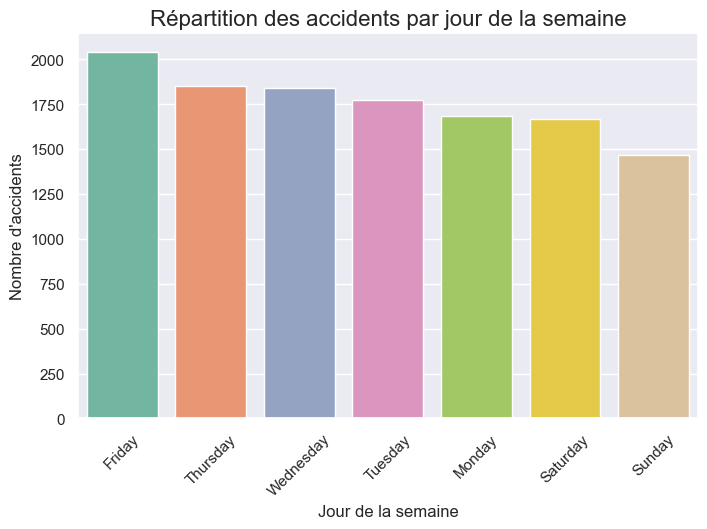

In [12]:
from matplotlib import pyplot as plt  # Importation de la bibliothèque matplotlib pour la création de graphiques
import seaborn as sns  # Importation de seaborn pour des visualisations statistiques avancées

plt.figure(figsize=(8, 5))  # Définir la taille de la figure du graphique

# Création d'un graphique à barres pour compter le nombre d'accidents par jour de la semaine.
sns.countplot(x='Day_of_week', data=data, order=data['Day_of_week'].value_counts().index, palette="Set2")


plt.title("Répartition des accidents par jour de la semaine", fontsize=16)  # Titre du graphique
plt.xlabel("Jour de la semaine", fontsize=12)  # Label de l'axe des X (jour de la semaine)
plt.ylabel("Nombre d'accidents", fontsize=12)  # Label de l'axe des Y (nombre d'accidents)

plt.xticks(rotation=45)  # Rotation des labels de l'axe des X de 45 degrés pour les rendre plus lisibles

plt.show()  # Afficher le graphique




### Analyse rapide :
- **Jour avec le plus d'accidents** : Vendredi enregistre le plus grand nombre d'accidents, ce qui peut s'expliquer par une circulation accrue en fin de semaine (sorties, déplacements professionnels ou privés).
- **Jour avec le moins d'accidents** : Dimanche a le plus faible nombre d'accidents, probablement dû à une diminution générale de la circulation ce jour-là.
- Les autres jours de la semaine (lundi à jeudi) montrent des valeurs proches, indiquant une répartition relativement stable des accidents en semaine.


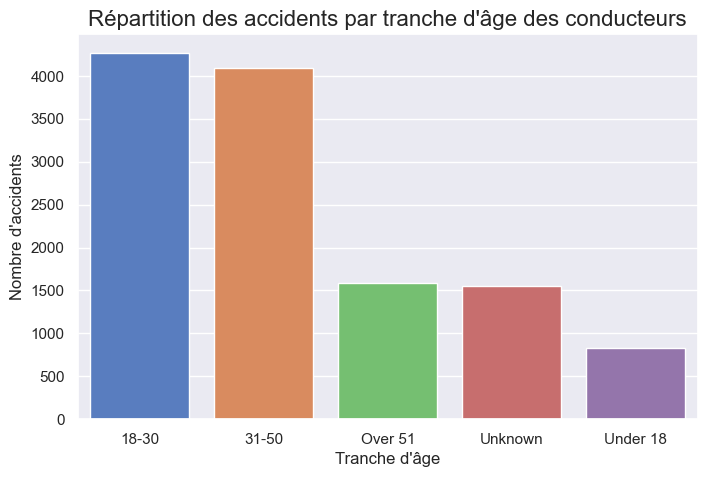

In [13]:
plt.figure(figsize=(8, 5))  # Définir la taille de la figure.


# Créer un graphique à barres (countplot) pour afficher la répartition des accidents en fonction des tranches d'âge des conducteurs.
sns.countplot(x='Age_band_of_driver', data=data, palette="muted", order=data['Age_band_of_driver'].value_counts().index)

# Ajouter un titre au graphique.
plt.title("Répartition des accidents par tranche d'âge des conducteurs", fontsize=16)

# Ajouter un label à l'axe des X (tranche d'âge des conducteurs).
plt.xlabel("Tranche d'âge", fontsize=12)

# Ajouter un label à l'axe des Y (nombre d'accidents).
plt.ylabel("Nombre d'accidents", fontsize=12)

# Afficher le graphique.
plt.show()



### Analyse rapide :
Le graphique montre la répartition des accidents en fonction des tranches d'âge des conducteurs. On observe que les conducteurs âgés de **18 à 30 ans** et de **31 à 50 ans** représentent les catégories avec le plus grand nombre d'accidents, avec des chiffres proches et significativement plus élevés que les autres groupes. Les conducteurs de plus de 51 ans, ceux dont l'âge est inconnu, et les conducteurs de moins de 18 ans ont un nombre d'accidents sensiblement inférieur, ces derniers étant les moins impliqués.

Cette répartition peut indiquer que les conducteurs plus jeunes et ceux en âge actif (18-50 ans) sont plus exposés aux accidents, probablement en raison de leur plus grande présence sur la route ou de comportements plus risqués. En revanche, les conducteurs plus âgés ou mineurs semblent moins impliqués, possiblement en raison de leur fréquence de conduite réduite ou de comportements plus prudents.

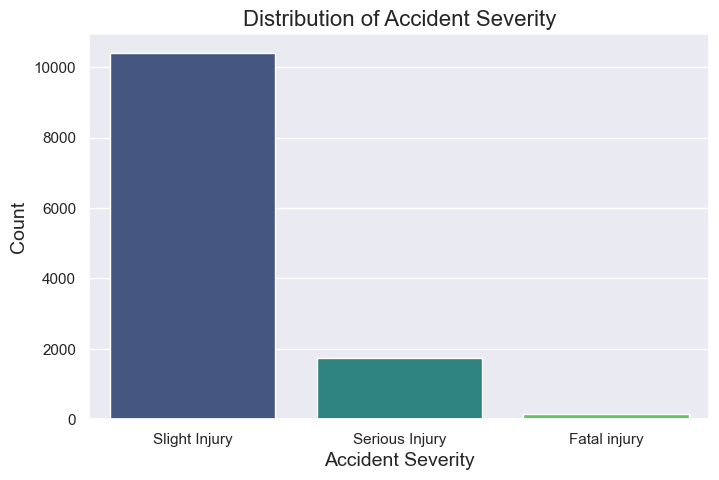

In [14]:
# Comptage des occurrences de chaque catégorie dans la colonne 'Accident_severity'
severity_counts = data['Accident_severity'].value_counts()

# Création d'une figure avec une taille de 8x5
plt.figure(figsize=(8, 5))

# Création d'un graphique en barres avec les indices de 'severity_counts' sur l'axe des X
# et les valeurs de 'severity_counts' (nombre d'occurrences) sur l'axe des Y
sns.barplot(x=severity_counts.index, y=severity_counts.values, palette="viridis")

# Ajout d'un titre au graphique
plt.title('Distribution of Accident Severity', fontsize=16)

# Ajout de l'étiquette pour l'axe des X
plt.xlabel('Accident Severity', fontsize=14)

# Ajout de l'étiquette pour l'axe des Y
plt.ylabel('Count', fontsize=14)

# Affichage du graphique
plt.show()


### Analyse rapide :

Le graphique montre la distribution des accidents selon leur gravité. On observe que la grande majorité des accidents signalés entraînent des **blessures légères**, ce qui peut indiquer que les accidents graves ou mortels sont nettement moins fréquents. Les **blessures graves** représentent une proportion modérée, tandis que les **blessures mortelles** sont très rares, avec un nombre d'occurrences presque négligeable.


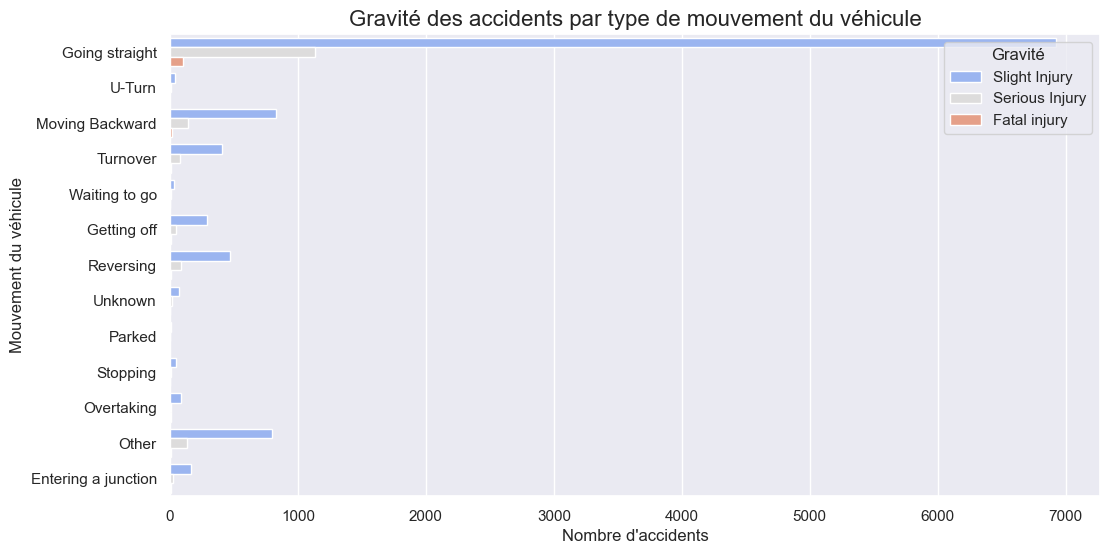

In [15]:
# Définir la taille de la figure.
plt.figure(figsize=(12, 6))

# Créer un graphique à barres (countplot) horizontal pour afficher la répartition des accidents en fonction du type de mouvement du véhicule.
sns.countplot(y='Vehicle_movement', hue='Accident_severity', data=data, palette="coolwarm")

# Ajouter un titre au graphique.
plt.title("Gravité des accidents par type de mouvement du véhicule", fontsize=16)

# Ajouter un label à l'axe des X (nombre d'accidents).
plt.xlabel("Nombre d'accidents", fontsize=12)

# Ajouter un label à l'axe des Y (type de mouvement du véhicule)
plt.ylabel("Mouvement du véhicule", fontsize=12)

# Ajouter une légende pour la couleur des barres qui représente la gravité des accidents.
plt.legend(title="Gravité", loc="upper right")

# Afficher le graphique.
plt.show()


### Analyse rapide :

Le graphique montre la répartition des accidents en fonction du type de mouvement des véhicules, avec une distinction par gravité (blessures légères, graves ou fatales). On peut tirer les observations suivantes :

1. **Mouvement dominant : "Going Straight"**  
   La majorité des accidents surviennent lorsque les véhicules se déplacent en ligne droite, avec une prédominance de blessures légères. Cela peut s'expliquer par la fréquence élevée de ce type de déplacement et par des accidents typiques comme les collisions avant-arrière.

2. **Accidents notables pour d'autres mouvements :**  
   Des accidents sont également observés pour des mouvements comme **"Moving Backward"**, **"Overtaking"** et **"Entering a junction"**, mais dans des proportions bien moindres.

3. **Gravité :**  
   Les blessures légères dominent dans presque toutes les catégories de mouvement. Les blessures graves et les accidents mortels sont présents mais en nombre relativement faible, ce qui est rassurant en termes de sécurité routière.

4. **Contexte spécifique :**  
   Les types de mouvement comme **"Reversing"** ou **"U-Turn"** ont des fréquences plus faibles d'accidents, mais la gravité peut être variable selon le contexte et les conditions de circulation.



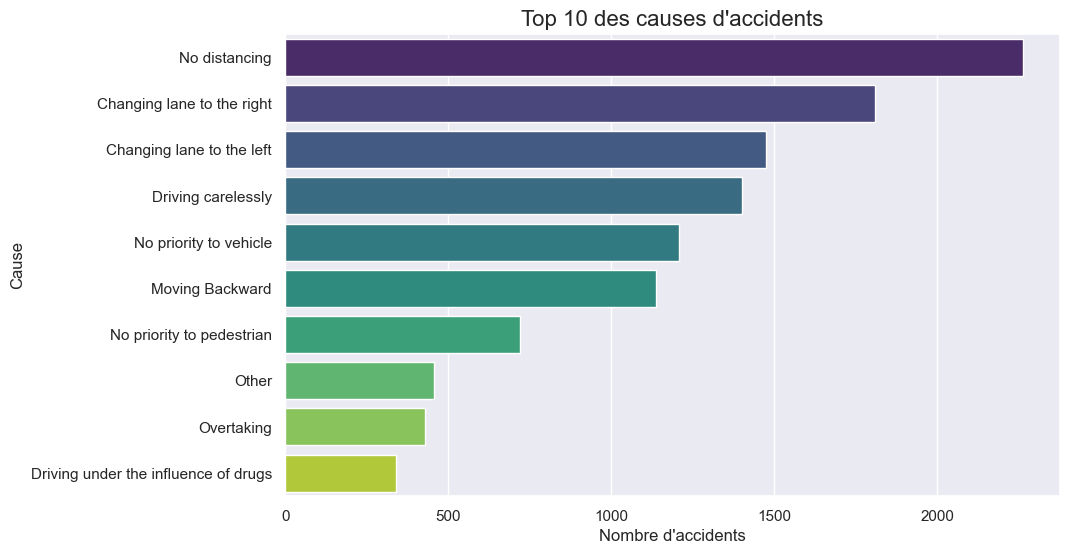

In [16]:
# Définir la taille de la figure à 10 pouces de large et 6 pouces de haut pour une meilleure lisibilité du graphique.
plt.figure(figsize=(10, 6))

cause_counts = data['Cause_of_accident'].value_counts().head(10)  # Top 10 causes

# Créer un graphique à barres horizontal (barplot) où l'axe X représente le nombre d'accidents pour chaque cause.
sns.barplot(x=cause_counts.values, y=cause_counts.index, palette="viridis")

# Ajouter un titre au graphique, avec une taille de police de 16 pour le rendre bien visible.
plt.title("Top 10 des causes d'accidents", fontsize=16)

# Ajouter un label à l'axe des X (nombre d'accidents).
plt.xlabel("Nombre d'accidents", fontsize=12)

# Ajouter un label à l'axe des Y (cause de l'accident).
plt.ylabel("Cause", fontsize=12)

# Afficher le graphique à l'écran.
plt.show()


### Analyse rapide :

Le graphique montre les 10 principales causes d'accidents, classées par fréquence.

1. **Cause principale : "No distancing"**  
   Cette cause est nettement la plus fréquente avec plus de 2000 incidents, ce qui souligne l'importance du respect des distances de sécurité sur la route.  

2. **Changement de voie**  
   Les comportements liés au changement de voie ("à droite" et "à gauche") sont des causes majeures, indiquant un besoin d'éducation sur la signalisation et la vigilance lors de ces manœuvres.  

3. **Conduite imprudente**  
   La conduite imprudente figure également parmi les causes importantes, ce qui reflète un manque d’attention ou d’adaptation aux conditions de circulation.  

4. **Priorité non respectée**  
   Le non-respect des priorités, qu’il s’agisse de véhicules ou de piétons, est une cause importante, soulignant des comportements dangereux en intersections ou passages piétons.  

5. **Autres observations**  
   - Les accidents liés à des comportements moins fréquents, comme "Driving under the influence of drugs", restent significatifs mais nettement inférieurs aux principales causes.  
   - Les comportements inattentifs, comme "Moving backward", contribuent également au risque routier.  


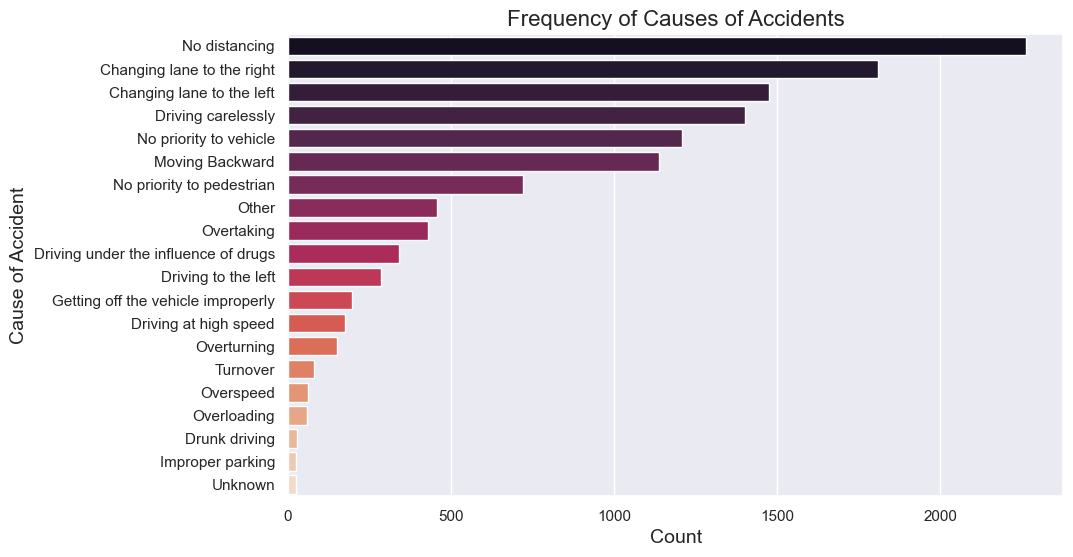

In [17]:
# Création d'une figure avec une taille de 10x6
plt.figure(figsize=(10, 6))

# Création d'un graphique en barres avec countplot pour afficher la fréquence des causes d'accidents
sns.countplot(data=data, y='Cause_of_accident', order=data['Cause_of_accident'].value_counts().index, palette="rocket")

# Ajout d'un titre explicatif au graphique
plt.title('Frequency of Causes of Accidents', fontsize=16)

# Ajout de l'étiquette pour l'axe des X (le nombre d'accidents par cause)
plt.xlabel('Count', fontsize=14)

# Ajout de l'étiquette pour l'axe des Y (les différentes causes d'accidents)
plt.ylabel('Cause of Accident', fontsize=14)

# Affichage du graphique
plt.show()


### Analyse rapide :

Le graphique montre la répartition des accidents en fonction du type de mouvement des véhicules, avec une distinction par gravité (blessures légères, graves ou fatales) :

1. **Mouvement dominant : "Going Straight"**  
   La majorité des accidents surviennent lorsque les véhicules se déplacent en ligne droite, avec une prédominance de blessures légères. Cela peut s'expliquer par la fréquence élevée de ce type de déplacement et par des accidents typiques comme les collisions avant-arrière.

2. **Accidents notables pour d'autres mouvements :**  
   Des accidents sont également observés pour des mouvements comme **"Moving Backward"**, **"Overtaking"** et **"Entering a junction"**, mais dans des proportions bien moindres.

3. **Gravité :**  
   Les blessures légères dominent dans presque toutes les catégories de mouvement. Les blessures graves et les accidents mortels sont présents mais en nombre relativement faible, ce qui est rassurant en termes de sécurité routière.

4. **Contexte spécifique :**  
   Les types de mouvement comme **"Reversing"** ou **"U-Turn"** ont des fréquences plus faibles d'accidents, mais la gravité peut être variable selon le contexte et les conditions de circulation.


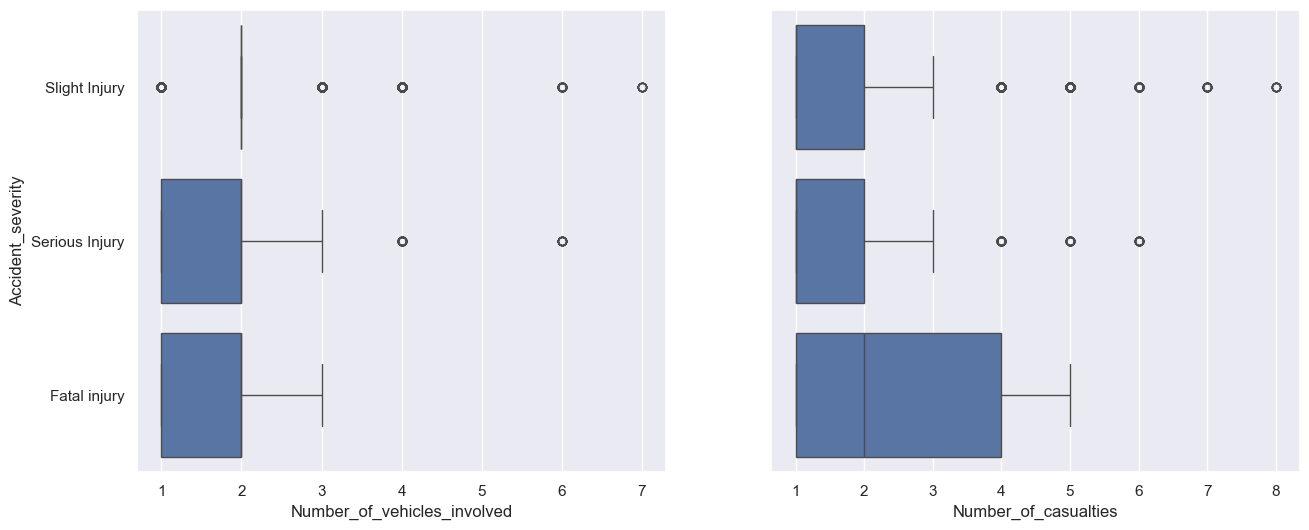

In [18]:
# Création d'une figure avec deux sous-graphes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6))

# Création d'un graphique en boîte (boxplot) pour visualiser la relation entre le nombre de véhicules impliqués
# et la gravité des accidents.
sns.boxplot(data = data, x = 'Number_of_vehicles_involved', y = 'Accident_severity', ax = ax1)

# Création d'un graphique en boîte (boxplot) pour visualiser la relation entre le nombre de blessés
# et la gravité des accidents.

sns.boxplot(data = data, x = 'Number_of_casualties', y = 'Accident_severity', ax = ax2).set(yticklabels = [])

# Suppression de l'étiquette de l'axe Y du second graphique (ax2)
ax2.set_ylabel('')

# Affichage des deux graphiques côte à côte
plt.show()


Ce graphique comporte deux visualisations en boîte (boxplots) montrant la relation entre la gravité des accidents et deux facteurs clés : le nombre de véhicules impliqués et le nombre de victimes :  

 **1. Nombre de véhicules impliqués**  
   - Les accidents **mortels** (Fatal injury) impliquent souvent **1 à 3 véhicules**. Les valeurs aberrantes (outliers) indiquent que quelques accidents très graves ont impliqué jusqu'à 7 véhicules.  
   - Les accidents **graves** (Serious injury) montrent une tendance similaire, principalement entre **1 et 3 véhicules**, mais avec une distribution un peu plus étendue.  
   - Les accidents avec **blessures légères** (Slight injury) sont fortement concentrés sur des cas avec un seul véhicule impliqué.  

 **2. Nombre de victimes**  
   - Les accidents **mortels** affichent une large distribution du nombre de victimes, allant de **1 à 5**, avec des cas exceptionnels atteignant jusqu'à 8 victimes.  
   - Les accidents **graves** ont généralement entre **1 et 3 victimes**, avec des valeurs aberrantes légèrement plus fréquentes.  
   - Les accidents **légers** sont concentrés autour de **1 ou 2 victimes**, avec très peu de dispersion.  

 **Conclusions :**  
   - **Accidents graves et mortels** : Ils impliquent généralement plusieurs véhicules ou un nombre plus élevé de victimes, reflétant des incidents à fort impact.  
   - **Accidents légers** : Souvent limités à un seul véhicule et un faible nombre de victimes.  


## 3. Pretraitement des données
#### 3.1. Standardisation  
- Les valeurs catégoriques sont standarisé pour garantir leur cohérence :  
  - `Unknown` est remplacé par `unknown`.  
  - `Other` est remplacé par `other`.  
  - `Unknown or other` est regroupé sous `other`.  
- La colonne `Age_band_of_casualty` subit une transformation spécifique :  
  - La valeur `5` est renommée en `Under 18` pour plus de clarté.

In [104]:
# Standardisation des valeurs
data = data.replace('Unknown', 'unknown')
data = data.replace('Other', 'other')
data = data.replace('Unknown or other', 'other')


In [106]:
# Convertir unknown/other/na à nan
data = data.replace('unknown', np.nan)
data = data.replace('other', np.nan)
data = data.replace('na', np.nan)

#### 3.2. Traitement des valeurs manquates

In [109]:
# afficher le pourcentage des valeurs nulls
missing_percentage = (data.isnull().sum() / len(data)) * 100
print(missing_percentage)

Time                            0.000000
Day_of_week                     0.000000
Age_band_of_driver             12.569016
Sex_of_driver                   1.445274
Educational_level               6.828516
Vehicle_driver_relation         5.813576
Driving_experience              6.999026
Type_of_vehicle                17.521923
Owner_of_vehicle                4.092238
Service_year_of_vehicle        55.302046
Defect_of_vehicle              35.945112
Area_accident_occured          33.127639
Lanes_or_Medians               17.067230
Road_allignment                 1.152972
Types_of_Junction              12.366028
Road_surface_type               2.752517
Road_surface_conditions         0.000000
Light_conditions                0.000000
Weather_conditions              4.774277
Type_of_collision               1.583306
Number_of_vehicles_involved     0.000000
Number_of_casualties            0.000000
Vehicle_movement               10.823319
Casualty_class                 36.075024
Sex_of_casualty 

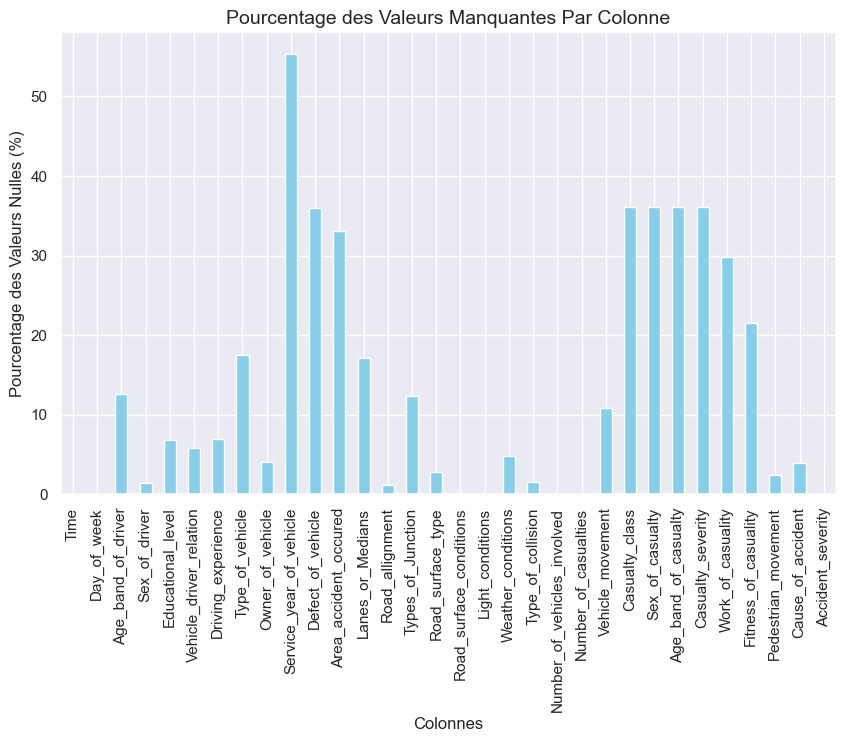

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculer le pourcentage des valeurs nulles
missing_percentage = (data.isnull().sum() / len(data)) * 100

# Afficher les résultats sous forme de graphique
plt.figure(figsize=(10, 6))
missing_percentage.plot(kind='bar', color='skyblue')

# Ajouter les titres et labels
plt.title('Pourcentage des Valeurs Manquantes Par Colonne', fontsize=14)
plt.xlabel('Colonnes', fontsize=12)
plt.ylabel('Pourcentage des Valeurs Nulles (%)', fontsize=12)
plt.xticks(rotation=90)  # Faire pivoter les noms des colonnes pour plus de lisibilité
plt.show()


On a trouvé des colonnes qui ont plus de 35% des valeurs nulls , c'est pour ça on a décidé de les vérifier sur la matrice de corrélation puis les suppri,er

In [114]:
data.columns

Index(['Time', 'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver',
       'Educational_level', 'Vehicle_driver_relation', 'Driving_experience',
       'Type_of_vehicle', 'Owner_of_vehicle', 'Service_year_of_vehicle',
       'Defect_of_vehicle', 'Area_accident_occured', 'Lanes_or_Medians',
       'Road_allignment', 'Types_of_Junction', 'Road_surface_type',
       'Road_surface_conditions', 'Light_conditions', 'Weather_conditions',
       'Type_of_collision', 'Number_of_vehicles_involved',
       'Number_of_casualties', 'Vehicle_movement', 'Casualty_class',
       'Sex_of_casualty', 'Age_band_of_casualty', 'Casualty_severity',
       'Work_of_casuality', 'Fitness_of_casuality', 'Pedestrian_movement',
       'Cause_of_accident', 'Accident_severity'],
      dtype='object')

-  Dans cette partie , on va remplir les valeurs manquantes en utilisant la valeur la plus fréquente (mode) de chaque colonne

In [117]:
# Liste des colonnes à remplir avec leur mode
columns_to_fill_mode = [
    'Driving_experience', 'Age_band_of_driver', 'Type_of_vehicle',
    'Area_accident_occured', 'Road_allignment', 'Type_of_collision',
    'Vehicle_movement', 'Lanes_or_Medians', 'Types_of_Junction',
    'Educational_level', 'Vehicle_driver_relation', 'Owner_of_vehicle',
    'Road_surface_type', 'Sex_of_driver', 'Cause_of_accident',
    'Pedestrian_movement', 'Age_band_of_casualty', 'Weather_conditions','Fitness_of_casuality'
]

# Remplir les valeurs manquantes avec le mode de chaque colonne
for column in columns_to_fill_mode:
    data[column].fillna(data[column].mode()[0], inplace=True)


In [119]:
data.isnull().sum()

Time                              0
Day_of_week                       0
Age_band_of_driver                0
Sex_of_driver                     0
Educational_level                 0
Vehicle_driver_relation           0
Driving_experience                0
Type_of_vehicle                   0
Owner_of_vehicle                  0
Service_year_of_vehicle        6811
Defect_of_vehicle              4427
Area_accident_occured             0
Lanes_or_Medians                  0
Road_allignment                   0
Types_of_Junction                 0
Road_surface_type                 0
Road_surface_conditions           0
Light_conditions                  0
Weather_conditions                0
Type_of_collision                 0
Number_of_vehicles_involved       0
Number_of_casualties              0
Vehicle_movement                  0
Casualty_class                 4443
Sex_of_casualty                4443
Age_band_of_casualty              0
Casualty_severity              4443
Work_of_casuality           

#### 3.3. Traitement de la colonne Time
- 00:00:00 → 0 (minuit)
- 06:00:00 → 21600 (6 heures du matin)
- 12:00:00 → 43200 (12 heures, midi)
- 18:00:00 → 64800 (18 heures, 6 heures du soir)
- 24:00:00 → 86400 (minuit du jour suivant)

In [122]:
# Convertir time de hh:mm:ss format à seconds
def convert_to_seconds(x):
    h = int(x.split(':')[0])
    m = int(x.split(':')[1])
    s = int(x.split(':')[2])
    return (h*60*60)+(m*60)+s

data['Time'] = data['Time'].apply(convert_to_seconds)

In [124]:
data['Time']

0        61320
1        61320
2        61320
3         3960
4         3960
         ...  
12311    58500
12312    64800
12313    50100
12314    50100
12315    50100
Name: Time, Length: 12316, dtype: int64

#### 3.4. Encodage des données catégoriels
##### **3.4.1. Classification des variables**
Dans notre données , il y a 3 types des données  :
- numériques : de type int comme `Number_of_vehicles_involved`
- ordinales : qui ont un ordre ou un classement à respecter comme `Educational_level`
- non ordinales : qui n'ont pas un ordre à suivre comme `Type_of_vehicle`

In [127]:
numerical_cols = ['Time', 'Number_of_vehicles_involved', 'Number_of_casualties']
ordinal_cols = ['Age_band_of_driver', 'Educational_level','Driving_experience', 'Light_conditions']
non_ordinal_cols = [x for x in data.columns if x not in numerical_cols + ordinal_cols]

##### **3.4.2. Encodage des valeurs ordinales**
Pour chaque colonne spécifiée dans la liste des colonnes ordinales, nous utiliserons un dictionnaire de mappage pour remplacer les valeurs catégorielles par des valeurs numériques.


In [130]:
# creation de mappings
Age_band_of_driver_dict = {'Under 18' : 1, '18-30' : 2, '31-50' : 3, 'Over 51' : 4,  1 : 1, 2 : 2, 3 : 3, 4 : 4, 10 : 10}
Educational_level_dict = {'Illiterate' : 1, 'Writing & reading' : 2, 'Elementary school' : 3, 'Junior high school' : 4, 'High school' : 5, 'Above high school' : 6,  1 : 1, 2 : 2, 3 : 3, 4 : 4, 5 : 5, 6 : 6, 10 : 10}
Driving_experience_dict = {'Below 1yr' : 1, '1-2yr' : 2, '2-5yr' : 3, '5-10yr' : 4, 'Above 10yr' : 5, 'No Licence' : 0,  1 : 1, 2 : 2, 3 : 3, 4 : 4, 5 : 5, 8 : 8, 10 : 10}
Light_conditions_dict = {'Darkness - no lighting' : 1, 'Darkness - lights lit' : 2, 'Daylight' : 3, 1 : 1, 2 : 2, 3 : 3}
Accident_severity_dict = {'Slight Injury' : 1, 'Serious Injury' : 2, 'Fatal injury' : 3, 1 : 1, 2 : 2, 3 : 3}

In [132]:
encoder_dict = {'Age_band_of_driver' : Age_band_of_driver_dict,
                       'Educational_level' : Educational_level_dict,
                       'Driving_experience' : Driving_experience_dict,
                       'Light_conditions' : Light_conditions_dict,
                       'Accident_severity' : Accident_severity_dict
                      }

In [134]:
# remplacer les valeurs
for feature in ordinal_cols:
    
    if feature in encoder_dict:
        data[feature] = data[feature].map(encoder_dict[feature])

In [136]:
data.head()

Time Day_of_week  Age_band_of_driver Sex_of_driver  Educational_level  \
0  61320      Monday                   2          Male                  6   
1  61320      Monday                   3          Male                  4   
2  61320      Monday                   2          Male                  4   
3   3960      Sunday                   2          Male                  4   
4   3960      Sunday                   2          Male                  4   

  Vehicle_driver_relation  Driving_experience      Type_of_vehicle  \
0                Employee                   2           Automobile   
1                Employee                   5  Public (> 45 seats)   
2                Employee                   2      Lorry (41?100Q)   
3                Employee                   4  Public (> 45 seats)   
4                Employee                   3           Automobile   

  Owner_of_vehicle Service_year_of_vehicle  ... Vehicle_movement  \
0            Owner              Above 10yr  ...   Going straight   
1            Owner                 5-10yrs  ...   Going straight   
2            Owner                     NaN  ...   Going straight   
3     Governmental                     NaN  ...   Going straight   
4            Owner                 5-10yrs  ...   Going straight   

    Casualty_class Sex_of_casualty Age_band_of_casualty Casualty_severity  \
0              NaN             NaN                18-30               NaN   
1              NaN             NaN                18-30               NaN   
2  Driver or rider            Male                31-50                 3   
3       Pedestrian          Female                18-30                 3   
4              NaN             NaN                18-30               NaN   

  Work_of_casuality Fitness_of_casuality  Pedestrian_movement  \
0               NaN               Normal     Not a Pedestrian   
1               NaN               Normal     Not a Pedestrian   
2            Driver               Normal     Not a Pedestrian   
3            Driver               Normal     Not a Pedestrian   
4               NaN               Normal     Not a Pedestrian   

            Cause_of_accident Accident_severity  
0             Moving Backward     Slight Injury  
1                  Overtaking     Slight Injury  
2   Changing lane to the left    Serious Injury  
3  Changing lane to the right     Slight Injury  
4                  Overtaking     Slight Injury  

[5 rows x 32 columns]

##### **3.4.2. Encodage des valeurs non ordinales**
On a utilisé Label Encoding qui attribue un numéro unique à chaque catégorie, ce qui réduit la dimensionnalité du dataset.

In [140]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
# Appliquer le Label Encoding pour chaque colonne de la liste
for col in non_ordinal_cols:
    data[col] = label_encoder.fit_transform(data[col])

In [142]:
data.head()

Time  Day_of_week  Age_band_of_driver  Sex_of_driver  Educational_level  \
0  61320            1                   2              1                  6   
1  61320            1                   3              1                  4   
2  61320            1                   2              1                  4   
3   3960            3                   2              1                  4   
4   3960            3                   2              1                  4   

   Vehicle_driver_relation  Driving_experience  Type_of_vehicle  \
0                        0                   2                0   
1                        0                   5               10   
2                        0                   2                5   
3                        0                   4               10   
4                        0                   3                0   

   Owner_of_vehicle  Service_year_of_vehicle  ...  Vehicle_movement  \
0                 2                        3  ...                 2   
1                 2                        2  ...                 2   
2                 2                        5  ...                 2   
3                 0                        5  ...                 2   
4                 2                        2  ...                 2   

   Casualty_class  Sex_of_casualty  Age_band_of_casualty  Casualty_severity  \
0               3                2                     0                  3   
1               3                2                     0                  3   
2               0                1                     1                  2   
3               2                0                     0                  2   
4               3                2                     0                  3   

   Work_of_casuality  Fitness_of_casuality  Pedestrian_movement  \
0                  5                     2                    5   
1                  5                     2                    5   
2                  0                     2                    5   
3                  0                     2                    5   
4                  5                     2                    5   

   Cause_of_accident  Accident_severity  
0                  9                  2  
1                 15                  2  
2                  0                  1  
3                  1                  2  
4                 15                  2  

[5 rows x 32 columns]

In [144]:
data['Light_conditions'].fillna(data['Light_conditions'].mode()[0], inplace=True)

##### **3.4.2. Matrice de corrélation**


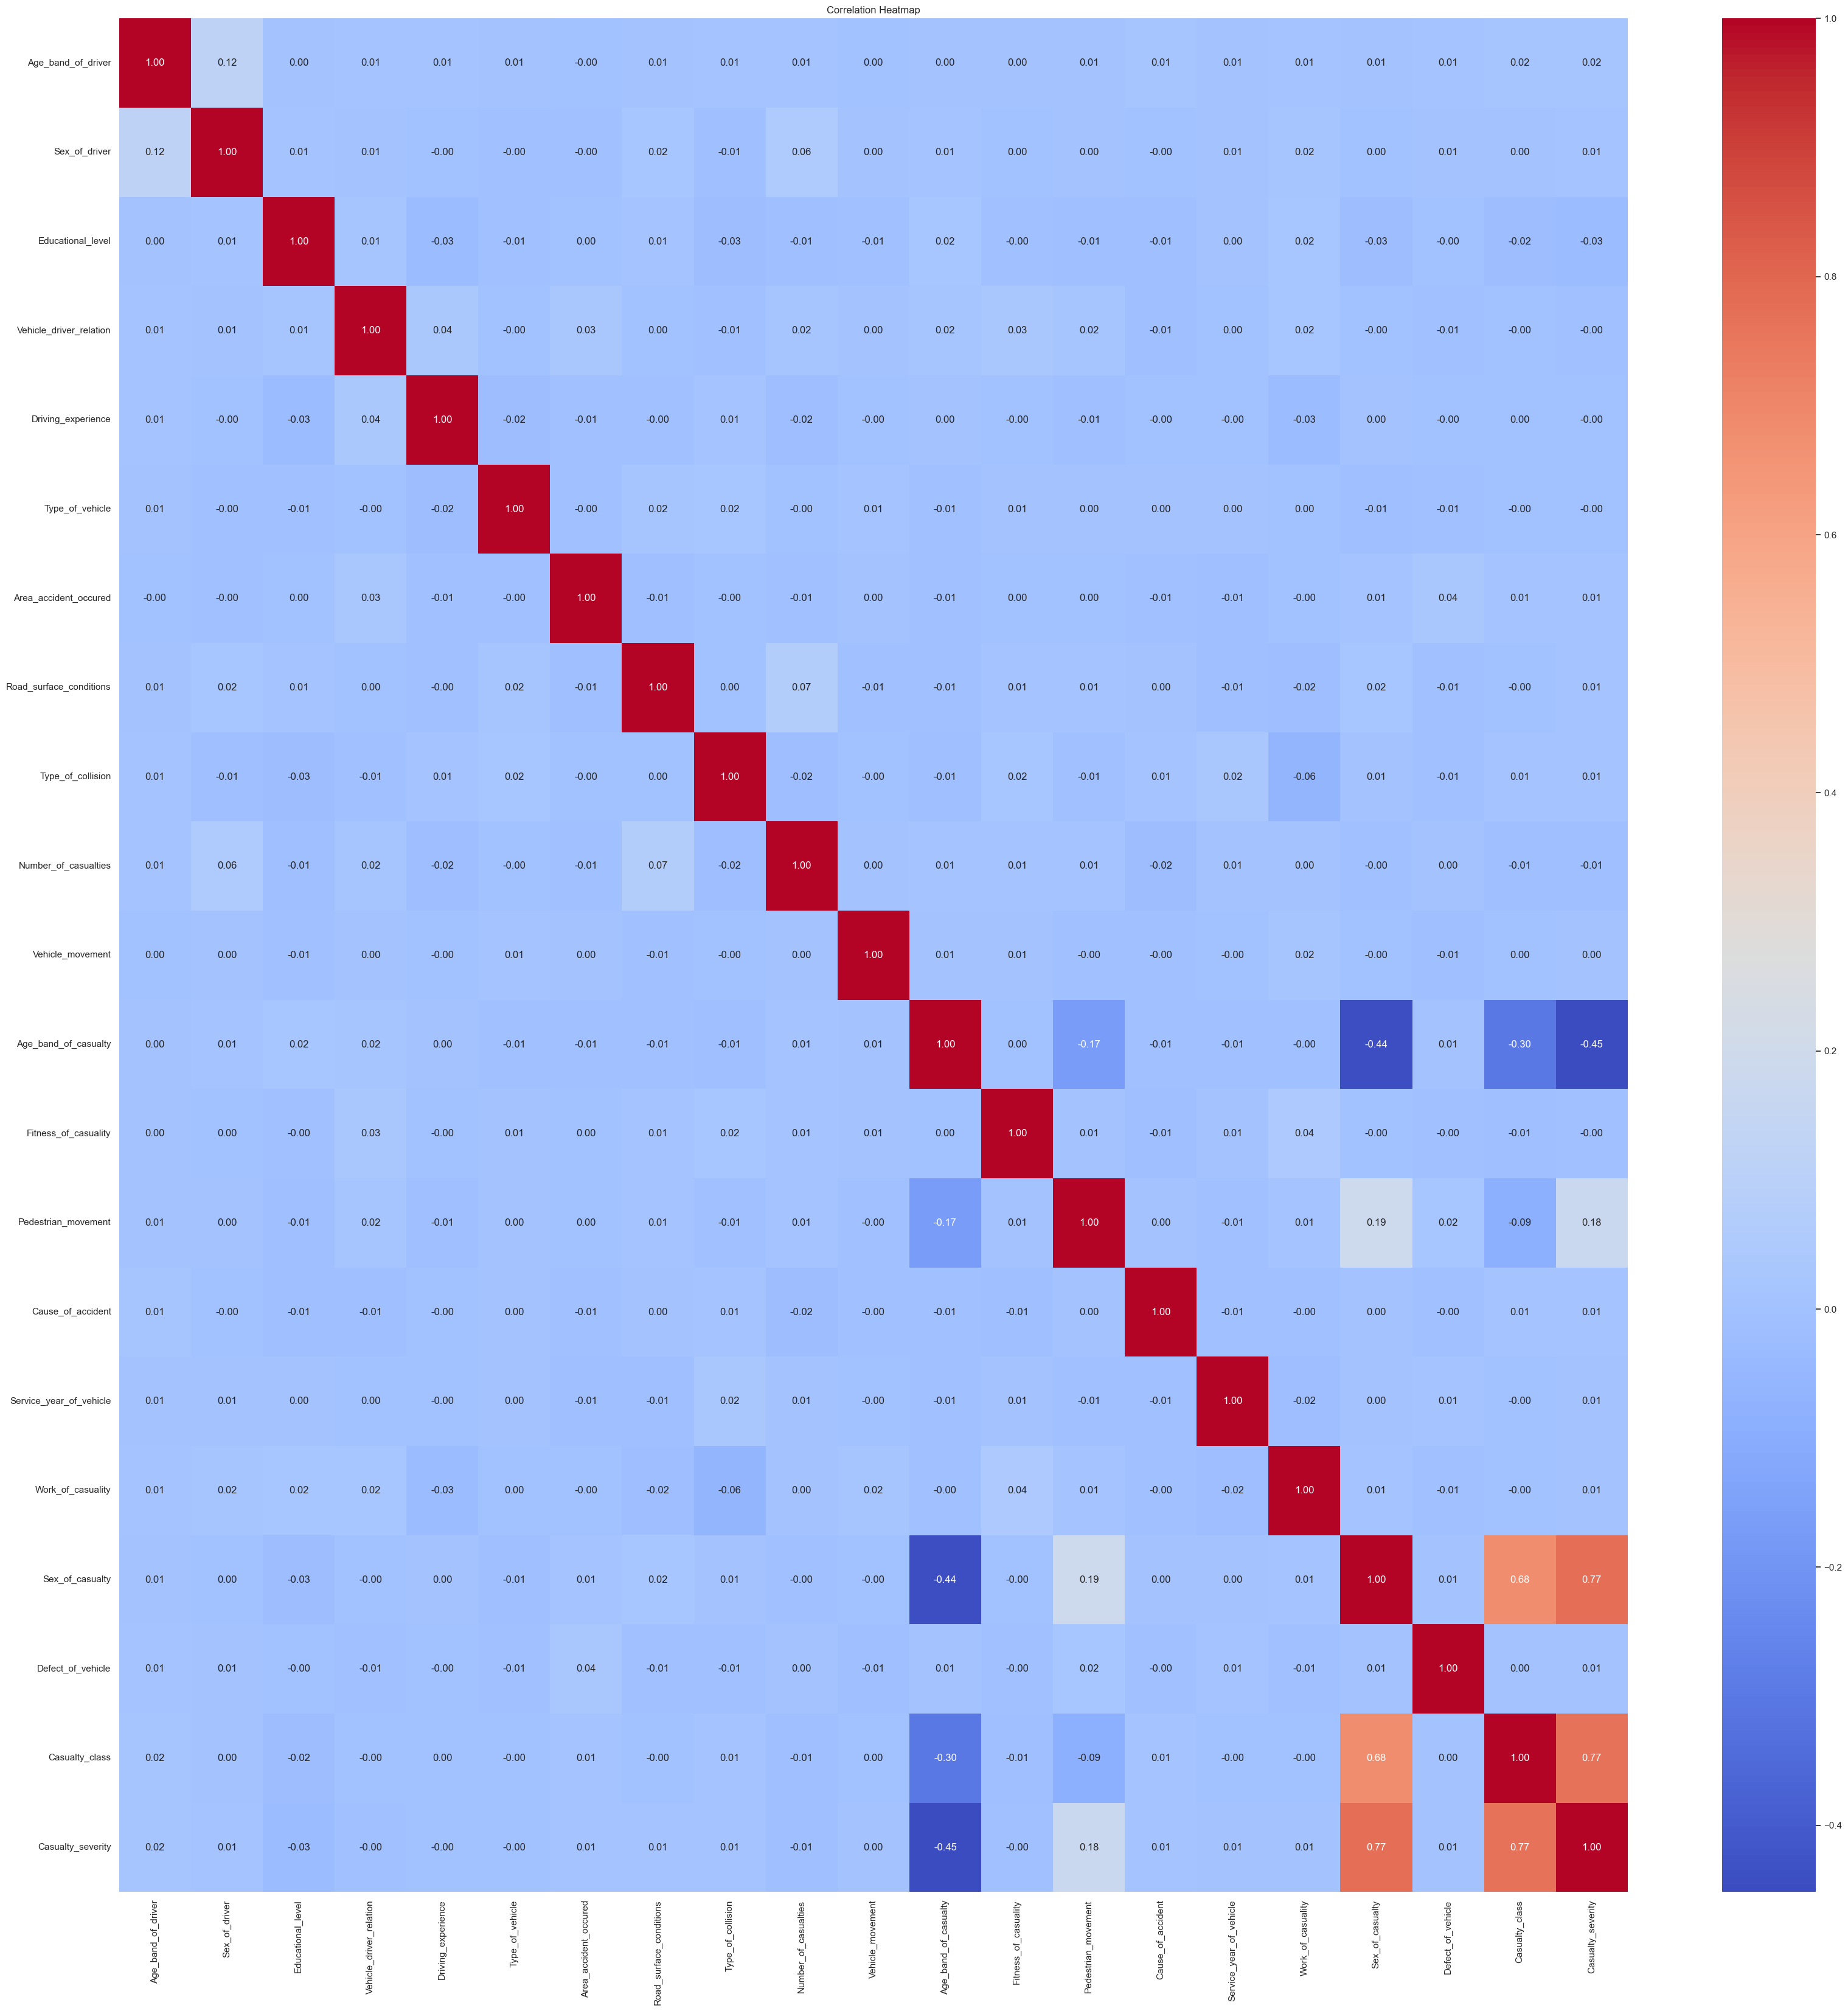

In [147]:
# Choisir les colonnes disponibles et spécifier la colonne cible
available_columns =['Age_band_of_driver', 'Sex_of_driver',
       'Educational_level', 'Vehicle_driver_relation', 'Driving_experience',
       'Type_of_vehicle',  'Area_accident_occured', 
       'Road_surface_conditions',
       'Type_of_collision',
       'Number_of_casualties', 'Vehicle_movement','Age_band_of_casualty','Fitness_of_casuality', 'Pedestrian_movement',
       'Cause_of_accident','Service_year_of_vehicle', 'Work_of_casuality','Sex_of_casualty','Defect_of_vehicle',"Casualty_class","Casualty_severity"]


# Calculer la matrice de corrélation entre les colonnes numériques encodées
# Cette matrice montre la force et la direction des relations linéaires entre les variables
correlation_matrix = data[available_columns].corr()

# Visualiser la matrice de corrélation sous forme de carte thermique (heatmap)
#  définit les couleurs allant du bleu (corrélation négative) au rouge (corrélation positive)
plt.figure(figsize=(40, 40))  # Définir la taille du graphique
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")  # Ajouter un titre
plt.show()  # Afficher le graphique


La matrice vise à :
- `Identifier les relations linéaires entre les différentes variables (valeurs comprises entre -1 et 1).`
- `Détecter les redondances ou dépendances parmi les variables.`
- `Guider la sélection ou la suppression de variables pour simplifier votre modèle`
- On a trouvé quelque colonne qui ont une forte correlation proche de 1 comme "casuality_class" avec "casuality_severity" , on a décidé de les supprimer 

In [149]:
# Suppression des colonnes
data.drop(['Service_year_of_vehicle', 'Work_of_casuality','Sex_of_casualty','Defect_of_vehicle',"Casualty_class","Casualty_severity"], axis=1, inplace=True)

## 4. AutoML avec PyCaret


### 4.1. Application de PyCaret

Avec la bibliothèque PyCaret, la fonction `setup()` est utilisée pour configurer l'environnement de travail en spécifiant le jeu de données (`data`), la variable cible (`'Accident_severity'`), et un identifiant de session (`session_id = 123`) pour assurer la reproductibilité. Après cette étape de configuration, la fonction `compare_models()` est appelée pour comparer différents modèles de classification. LightGBM est le plus performant.


In [ ]:
from pycaret.classification import *

In [ ]:
pip install pycaret

In [ ]:
pip install setuptools

In [17]:
from pycaret.classification import *
# configurer l'environnement de travail
s = setup(data, target = 'Accident_severity', session_id = 123)

In [18]:
# comparer les modèles
best = compare_models()

Processing:   0%|          | 0/65 [00:00<?, ?it/s]

### 4.2. Tester les performances du modèle

La matrice de confusion montre les performances du modèle *LGBMClassifier*. Le modèle prédit efficacement la classe majoritaire (classe 2) avec 3108 prédictions correctes, mais montre des difficultés à distinguer les classes 0 et 1. On observe des erreurs notables, notamment des classements de la classe 0 en classe 2 (41 fois).

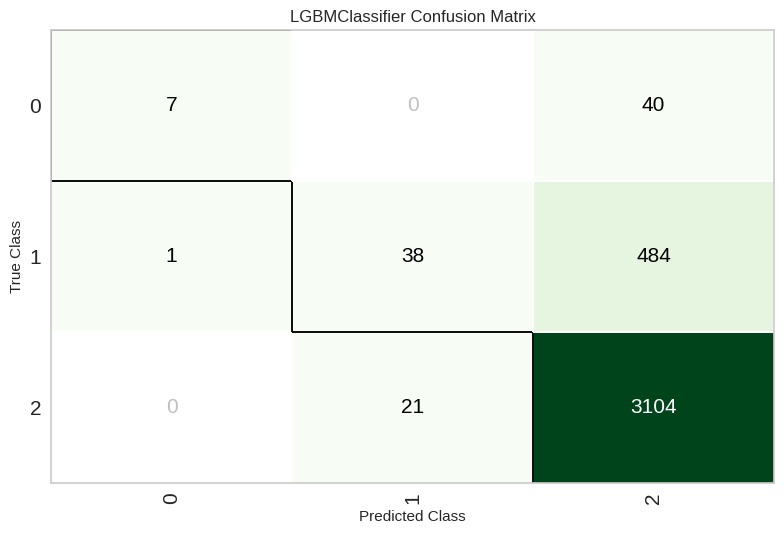

In [19]:
# afficher la matrice de confusion
plot_model(best, plot = 'confusion_matrix')

Les courbes ROC montrent les performances de classification pour chaque classe. Les AUC (Area Under Curve) indiquent une bonne capacité de distinction pour la classe 0 (AUC = 0.85), mais des performances plus faibles pour les classes 1 et 2 (AUC = 0.68 pour les deux). L'AUC micro-moyennée (0.94) suggère une bonne performance globale du modèle, tandis que l'AUC macro-moyennée (0.74) reflète un déséquilibre dans la performance entre les classes.

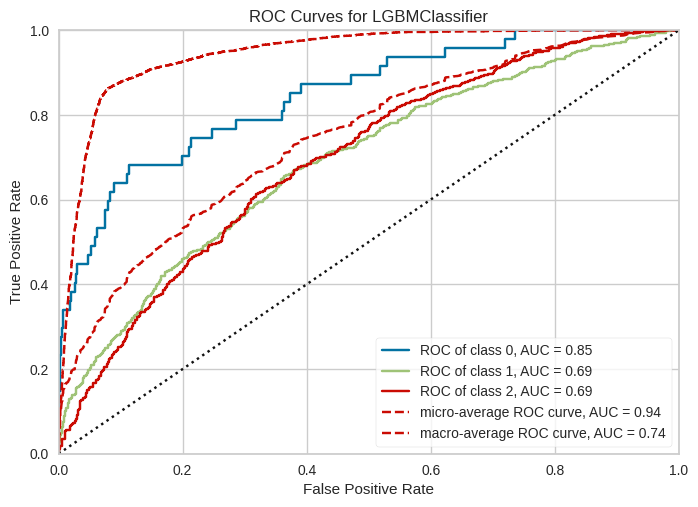

In [20]:
# afficher la courbe ROC-AUC
plot_model(best, plot = 'auc')

Le graphique d'importance des variables montre que la variable **Time** est de loin la plus influente pour le modèle, suivie par **Cause_of_accident** et **Day_of_week**. D'autres variables comme **Type_of_vehicle**, **Area_accident_occurred** et **Types_of_Junction** contribuent également de manière notable. Les variables liées au conducteur et aux victimes (par exemple, **Driving_experience**, **Age_band_of_driver**, et **Age_band_of_casualty**) jouent un rôle moins important dans les prédictions. Ces résultats mettent en lumière les facteurs clés influençant les prédictions du modèle.


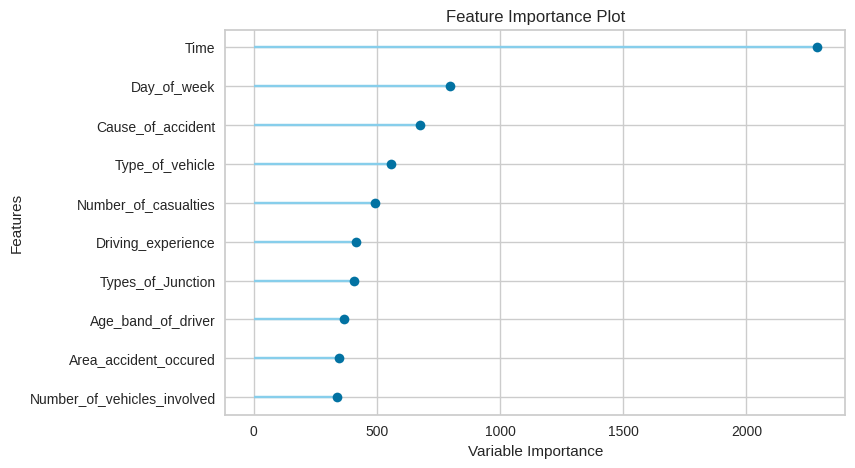

In [21]:
# afficher les colonnes importantes
plot_model(best, plot = 'feature')

# 5. Modélisation


## 5.1. Données d'entrainement et de test

Pour entraîner notre modèle, nous avons séparé les données en ensembles d'entraînement et de test. La variable cible '**Accident_severity**' représente la gravité des accidents, tandis que les autres colonnes constituent les caractéristiques indépendantes. Nous avons utilisé une division stratifiée pour maintenir une répartition équilibrée des classes dans les ensembles.

In [155]:
y = data['Accident_severity'] # variable cible
X = data.drop('Accident_severity', axis = 1) # variables indépendantes

In [157]:
# Ensemble d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.3, shuffle = True)

### SMOTE pour OVERSAMPLING
SMOTE (Synthetic Minority Over-sampling Technique) est une technique utilisée pour traiter les problèmes de déséquilibre des classes dans les jeux de données. Elle permet de suréchantillonner les classes minoritaires en générant des exemples synthétiques au lieu de simplement dupliquer les exemples existants.

Dans notre cas on a les classes sont déséquilibrées 
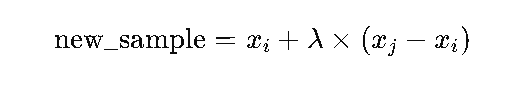

In [63]:
pip install imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [160]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

# Appliquer SMOTE
smote = SMOTE(random_state=42)

X_train, y_train= smote.fit_resample(X_train, y_train)

## 5.2. Random Forest


### Entrainement du modèle

 Nous utilisons `GridSearchCV` pour optimiser les hyperparamètres du modèle `RandomForestClassifier`. Les paramètres testés incluent :  
   - `n_estimators` : Nombre d'arbres dans la forêt.  
   - `max_depth` : Profondeur maximale des arbres pour contrôler leur complexité.    
   - `min_samples_split` : option pour contrôler le surapprentissage.  
   La validation croisée avec 3 plis permet d'obtenir une évaluation robuste des performances.

In [19]:
from sklearn.ensemble import RandomForestClassifier

# Initialisation du classificateur de forêt aléatoire

rf = RandomForestClassifier(random_state=42)

In [20]:
param_grid_random_forest = {
    'n_estimators': [100, 200,500],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5, 10],
}


In [28]:
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_random_forest,
    cv=3,
    scoring='accuracy',
    verbose=3,
    error_score='raise'
)
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3] END max_depth=10, min_samples_split=2, n_estimators=100;, score=0.800 total time=   1.3s
[CV 2/3] END max_depth=10, min_samples_split=2, n_estimators=100;, score=0.898 total time=   1.4s
[CV 3/3] END max_depth=10, min_samples_split=2, n_estimators=100;, score=0.899 total time=   1.4s
[CV 1/3] END max_depth=10, min_samples_split=2, n_estimators=200;, score=0.799 total time=   2.9s
[CV 2/3] END max_depth=10, min_samples_split=2, n_estimators=200;, score=0.898 total time=   2.9s
[CV 3/3] END max_depth=10, min_samples_split=2, n_estimators=200;, score=0.902 total time=   2.9s
[CV 1/3] END max_depth=10, min_samples_split=2, n_estimators=500;, score=0.800 total time=   6.3s
[CV 2/3] END max_depth=10, min_samples_split=2, n_estimators=500;, score=0.901 total time=   6.4s
[CV 3/3] END max_depth=10, min_samples_split=2, n_estimators=500;, score=0.906 total time=   6.1s
[CV 1/3] END max_depth=10, min_samples_split=5, n_estimat

GridSearchCV(cv=3, error_score='raise',
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [10, 20], 'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 500]},
             scoring='accuracy', verbose=3)

### Tester les performences du modèle

Le rapport de classification montre une précision globale de **82 %**.La classe **2** est bien prédite (F1-score de **0,90**), tandis que les classes **0** et **1** sont mal prises en compte, avec des F1-scores de **0,14** et **0,23** respectivement.

In [29]:
best_model_rf = grid_search.best_estimator_

In [30]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Prédiction des étiquettes de test
y_pred_rf = best_model_rf.predict(X_test)

# Affichage du rapport de classification
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.44      0.09      0.14        47
           1       0.31      0.18      0.23       523
           2       0.86      0.94      0.90      3125

    accuracy                           0.82      3695
   macro avg       0.54      0.40      0.42      3695
weighted avg       0.78      0.82      0.79      3695



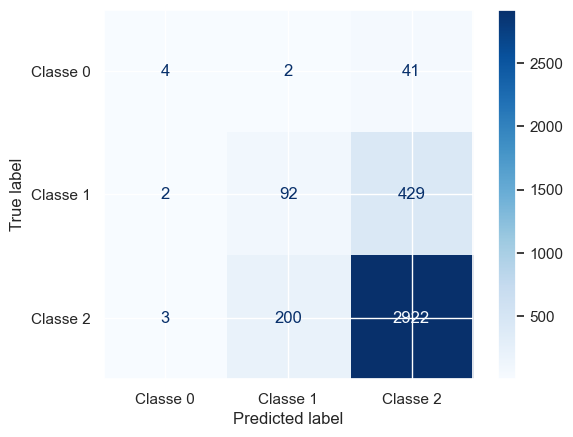

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred_rf)

# Affichage de la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Classe 0', 'Classe 1','Classe 2'])  # Modifier les labels selon vos classes
disp.plot(cmap='Blues')


Le graphique représente les courbes ROC pour les trois classes. La classe **0** présente une bonne performance avec une AUC de **0.81**, indiquant une capacité élevée à distinguer les exemples positifs des négatifs. En revanche, les classes **1** et **2** ont une AUC de **0.67** , ce qui reflète une performance plus modérée.

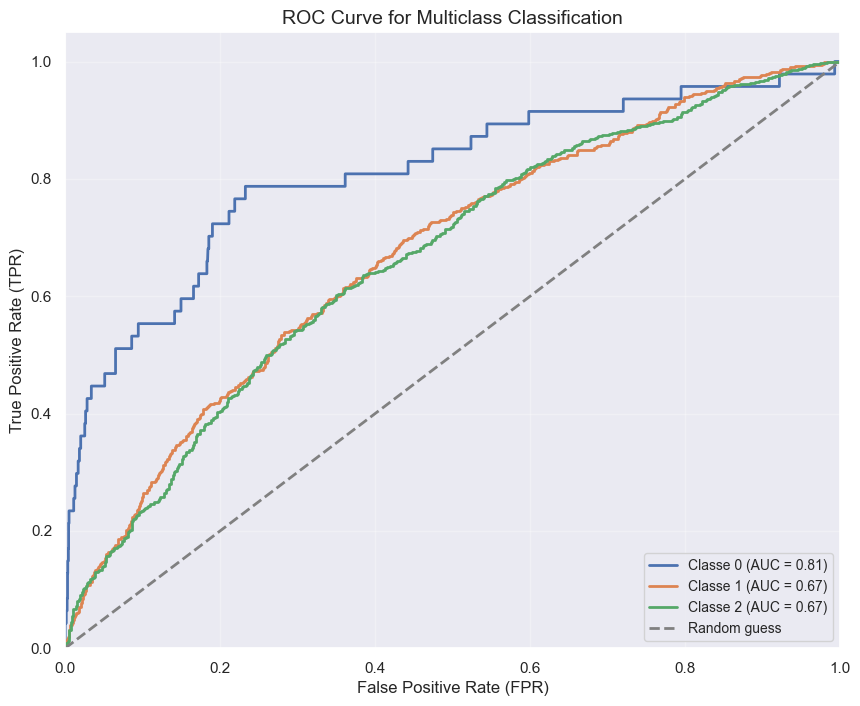

In [32]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt


# Binariser les labels
classes = np.unique(y_test)
y_test_binarized = label_binarize(y_test, classes=classes)
y_proba_rf = grid_search.predict_proba(X_test)  # Probabilités de chaque classe

# Tracer les courbes ROC pour chaque classe
plt.figure(figsize=(10, 8))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_proba_rf[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Classe {class_label} (AUC = {roc_auc:.2f})')

# Ajouter des éléments au graphique
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve for Multiclass Classification', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.show()


## 5.3. XGBoost

### Entrainement du modèle


Nous utilisons `GridSearchCV` pour optimiser les hyperparamètres du modèle `XGBClassifier`. Les paramètres testés incluent :  
   - `n_estimators` : Nombre d'arbres dans le modèle.  
   - `max_depth` : Profondeur maximale des arbres pour ajuster leur complexité.  
   - `learning_rate` : Taux d'apprentissage pour contrôler l'impact de chaque arbre ajouté.  
   - `subsample` : Taux d'échantillonnage des données utilisé pour chaque arbre, permettant de réduire le surapprentissage.  

In [22]:
pip install xgboost

  Using cached xgboost-2.1.3-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-2.1.3-py3-none-win_amd64.whl (124.9 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
from xgboost import XGBClassifier
# Initialisation du classificateur XGBoost
xgb = XGBClassifier(random_state=42)

In [24]:
# Hyperparamètres à tester
param_grid = {
    'n_estimators': [100, 200, 500],  # Plus d'arbres pour de meilleures performances
    'max_depth': [10, 20],  # Arbres plus profonds pour plus de complexité
    'learning_rate': [0.01, 0.1],  # Taux d'apprentissage
    'subsample': [0.8, 1.0],  # Pour l'échantillonnage
}


In [99]:
pip install --upgrade xgboost


Note: you may need to restart the kernel to use updated packages.


In [25]:
# Recherche de grille avec validation croisée
grid_search_xgboost = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=3,
    error_score='raise'
)
# Entraînement du modèle
grid_search_xgboost.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.8;, score=0.815 total time=   1.7s
[CV 2/3] END learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.8;, score=0.911 total time=   2.1s
[CV 3/3] END learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.8;, score=0.912 total time=   1.7s
[CV 1/3] END learning_rate=0.01, max_depth=10, n_estimators=100, subsample=1.0;, score=0.810 total time=   1.5s
[CV 2/3] END learning_rate=0.01, max_depth=10, n_estimators=100, subsample=1.0;, score=0.883 total time=   1.7s
[CV 3/3] END learning_rate=0.01, max_depth=10, n_estimators=100, subsample=1.0;, score=0.889 total time=   1.6s
[CV 1/3] END learning_rate=0.01, max_depth=10, n_estimators=200, subsample=0.8;, score=0.826 total time=   3.1s
[CV 2/3] END learning_rate=0.01, max_depth=10, n_estimators=200, subsample=0.8;, score=0.930 total time=   3.1s
[CV 3/3] END learning_rate=0.01, max_depth=

GridSearchCV(cv=3, error_score='raise',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [10, 20],
                         'n_estimators': [100, 200, 500],
                         'subsample': [0.8, 1.0]},
             scoring='accuracy', verbose=3)

### Tester les performences du modèle

Le modèle montre un score pour la classe `1` (F1-score de 0.24) , par rapport à la classe `0` (F1-score de 0.18). La classe majoritaire (`2`) conserve de très bonnes performances (F1-score de 0.91).


In [33]:
best_model_xgb = grid_search_xgboost.best_estimator_

In [34]:

# Prédiction des étiquettes de test
y_pred_xgb = grid_search_xgboost.predict(X_test)

# Affichage du rapport de classification
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.50      0.11      0.18        47
           1       0.38      0.17      0.24       523
           2       0.86      0.95      0.91      3125

    accuracy                           0.83      3695
   macro avg       0.58      0.41      0.44      3695
weighted avg       0.79      0.83      0.80      3695



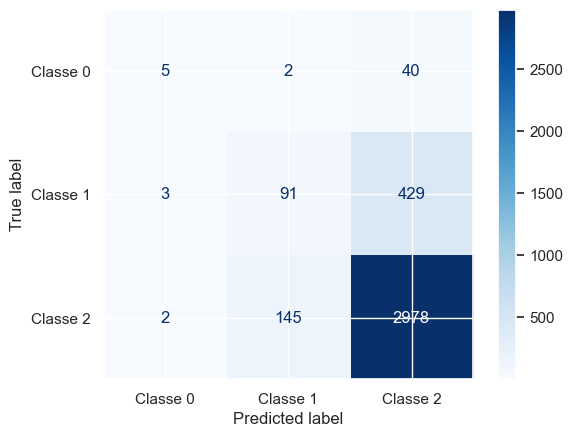

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred_xgb)

# Affichage de la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Classe 0', 'Classe 1','Classe 2'])  # Modifier les labels selon vos classes
disp.plot(cmap='Blues')


Le graphique montre les courbes ROC pour les trois classes, avec des AUC de **0.80** pour la classe 0, **0.68** pour les classes 1 et 2. 

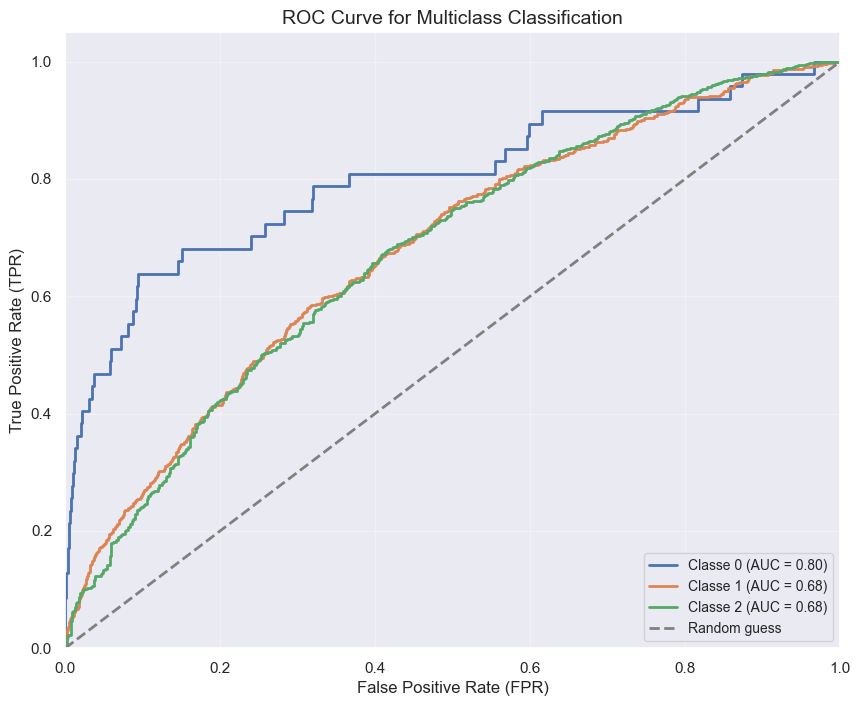

In [36]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt


# Binariser les labels
classes = np.unique(y_test)
y_test_binarized = label_binarize(y_test, classes=classes)
y_proba_xgb = grid_search_xgboost.predict_proba(X_test)  # Probabilités de chaque classe

# Tracer les courbes ROC pour chaque classe
plt.figure(figsize=(10, 8))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_proba_xgb[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Classe {class_label} (AUC = {roc_auc:.2f})')

# Ajouter des éléments au graphique
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve for Multiclass Classification', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.show()


## 5.4. LightGBM

### Entrainement du modèle

In [84]:
from lightgbm import LGBMClassifier

# Initialisation du classificateur LightGBM
lgbm = LGBMClassifier(random_state=42)

In [86]:
grid_search_lgbm = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=3,
    error_score='raise'
)

# Entraînement du modèle
grid_search_lgbm.fit(X_train, y_train)

NameError: name 'param_grid' is not defined

### Tester les performances du modèle

Le rapport de classification indique une précision globale de **83 %**. Les classes **0** et **2** sont prédites avec des F1-score de **0,34** et **0,90** , tandis que la classe **1** présentent un F1-score de **0,24** .

In [80]:
best_model_lgbm= grid_search_lgbm.best_estimator_

NameError: name 'grid_search_lgbm' is not defined

In [41]:
# Prédiction des étiquettes de test
from sklearn.metrics import classification_report

y_pred_lgbm = best_model_lgbm.predict(X_test)

# Affichage du rapport de classification
print(classification_report(y_test, y_pred_lgbm))

              precision    recall  f1-score   support

           0       0.91      0.21      0.34        47
           1       0.36      0.18      0.24       523
           2       0.86      0.95      0.90      3125

    accuracy                           0.83      3695
   macro avg       0.71      0.45      0.50      3695
weighted avg       0.79      0.83      0.80      3695



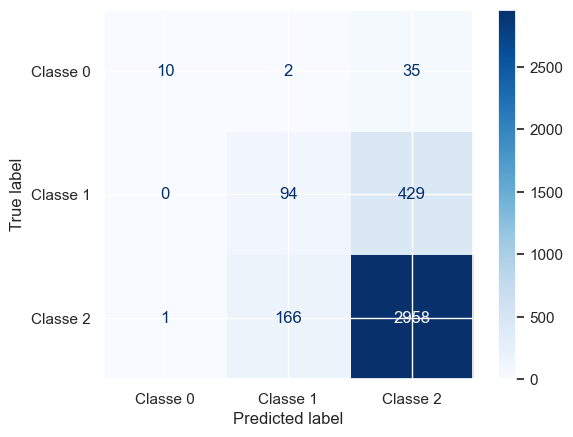

In [42]:
# Calcul de la matrice de confusion
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


cm = confusion_matrix(y_test, y_pred_lgbm)

# Affichage de la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Classe 0', 'Classe 1','Classe 2'])  # Modifier les labels selon vos classes
disp.plot(cmap='Blues')


Le graphique montre les courbes ROC pour les trois classes, avec des AUC de **0.82** pour la classe 0, **0.66** pour les classes 1 et 2.

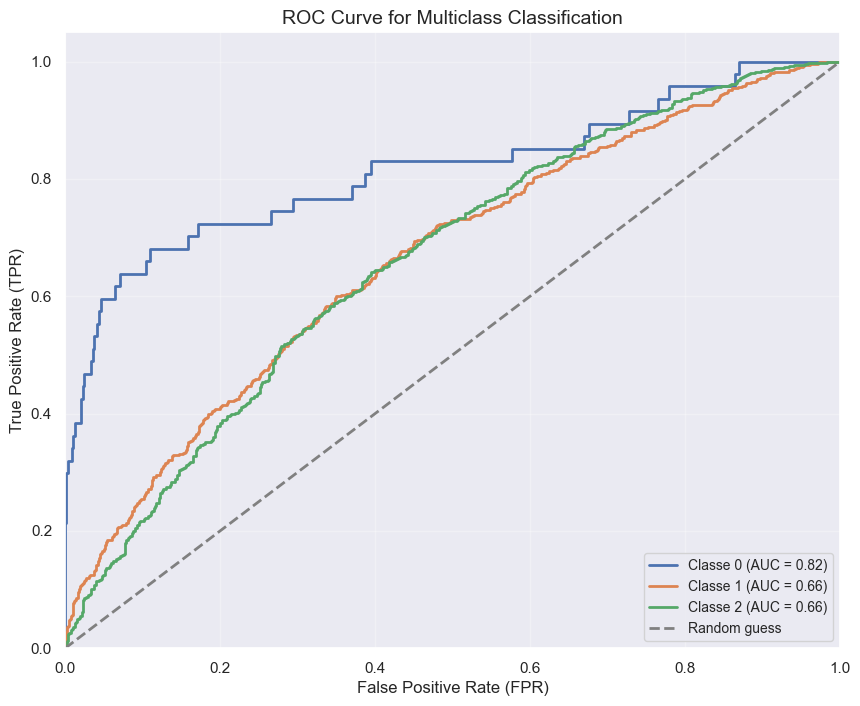

In [43]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt


# Binariser les labels
classes = np.unique(y_test)
y_test_binarized = label_binarize(y_test, classes=classes)
y_proba_lgbm = grid_search_lgbm.predict_proba(X_test)  # Probabilités de chaque classe

# Tracer les courbes ROC pour chaque classe
plt.figure(figsize=(10, 8))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_proba_lgbm[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Classe {class_label} (AUC = {roc_auc:.2f})')

# Ajouter des éléments au graphique
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve for Multiclass Classification', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.show()


# MLFLOW

In [162]:
pip install mlflow

In [164]:
import mlflow
import mlflow.sklearn

# RandomForest

## Suivi des expérimentations avec MLflow

Nous allons utiliser **MLflow** pour gérer et suivre l'entraînement d'un modèle de machine learning. Il crée une expérience, entraîne un **RandomForestClassifier**, et enregistre les **hyperparamètres**, **métriques de performance** (precision, recall, F1, accuracy), et le **modèle** dans un "run" MLflow. Cela permet de comparer facilement les différents essais et de suivre l'évolution des performances du modèle.


In [181]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import mlflow
import mlflow.sklearn

# Configuration de l'expérience MLflow
mlflow.set_experiment("AccidentClassif")

# Définir la grille d'hyperparamètres
param_grid = {
    'n_estimators': [100, 200,500],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5, 10],
}

# Initialisation du modèle
rf_model = RandomForestClassifier(random_state=42)

# Initialisation de GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model, 
    param_grid=param_grid, 
    cv=3, 
    scoring='accuracy', 
)

# Entraînement et recherche des meilleurs hyperparamètres
with mlflow.start_run(run_name="RandomForest"):
    grid_search.fit(X_train, y_train)

    # Meilleurs paramètres
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    # Prédictions sur l'ensemble de test
    y_pred_rf = best_model.predict(X_test)

    # Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred_rf)
    precision = precision_score(y_test, y_pred_rf, average='weighted')
    recall = recall_score(y_test, y_pred_rf, average='weighted')
    f1 = f1_score(y_test, y_pred_rf, average='weighted')

    # Enregistrement des métriques
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)

    # Enregistrement des meilleurs paramètres
    for param_name, param_value in best_params.items():
        mlflow.log_param(param_name, param_value)

    # Enregistrement du modèle
    mlflow.sklearn.log_model(best_model, "best_random_forest_model")

    print(f"Meilleurs paramètres trouvés : {best_params}")


2024/12/10 23:02:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Meilleurs paramètres trouvés : {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 500}


# Xgboost

Dans cette partie nous allons entraîner un modèle **XGBoost** pour la classification multiclasses et d’expérimenter avec plusieurs ensembles d’hyperparamètres. Les paramètres tels que `max_depth`, `learning_rate`,`subsample` et `n_estimators` sont définis et testés dans différentes configurations pour optimiser les performances du modèle.

Le processus d'entraînement inclut la prédiction sur un jeu de test et le calcul de diverses métriques de performance, comme la précision, le recall, le score F1 et l'accuracy.

Tous les résultats, y compris les hyperparamètres et les métriques de performance, sont enregistrés dans **MLflow**, permettant un suivi complet des différentes expérimentations et une comparaison facile des performances de chaque modèle.

In [ ]:
import mlflow
import mlflow.xgboost
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

# Configuration de MLflow
mlflow.set_experiment("AccidentClassif")

# Définir la grille d'hyperparamètres
param_grid = {
    'n_estimators': [100, 200, 500],  # Plus d'arbres pour de meilleures performances
    'max_depth': [10, 20],  # Arbres plus profonds pour plus de complexité
    'learning_rate': [0.01, 0.1],  # Taux d'apprentissage
    'subsample': [0.8, 1.0],  # Pour l'échantillonnage
}

# Initialisation du modèle
xgb_model = xgb.XGBClassifier(random_state=42)

# Configuration de GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',  # Optimisation basée sur F1-score pondéré
    cv=3,                   # Validation croisée à 5 plis
    error_score='raise'

)

# Entraînement et recherche des meilleurs hyperparamètres
with mlflow.start_run(run_name="XGBoost"):
    grid_search.fit(X_train, y_train)

    # Meilleurs paramètres trouvés
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    # Prédictions sur l'ensemble de test
    y_pred = best_model.predict(X_test)

    # Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Enregistrement des métriques dans MLflow
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)

    # Enregistrement des meilleurs paramètres
    for param_name, param_value in best_params.items():
        mlflow.log_param(param_name, param_value)

    # Enregistrement du modèle
    mlflow.xgboost.log_model(best_model, "best_xgboost_model")

    print(f"Meilleurs paramètres trouvés : {best_params}")


# LightGBM

Dans cette partie nous allons entraîner un modèle **LightGBM** pour la classification multiclasses et d’expérimenter avec plusieurs ensembles d’hyperparamètres. Les paramètres tels que `max_depth`, `learning_rate`,`subsample` et `n_estimators` sont définis et testés dans différentes configurations pour optimiser les performances du modèle.

Le processus d'entraînement inclut la prédiction sur un jeu de test et le calcul de diverses métriques de performance, comme la précision, le recall, le score F1 et l'accuracy.


In [175]:
import mlflow
import mlflow.sklearn
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV

# Configuration de MLflow
mlflow.set_experiment("AccidentClassif")

# Définir la grille de recherche
param_grid = {
    'n_estimators': [100, 200, 500],  # Plus d'arbres pour de meilleures performances
    'max_depth': [10, 20],  # Arbres plus profonds pour plus de complexité
    'learning_rate': [0.01, 0.1],  # Taux d'apprentissage
    'subsample': [0.8, 1.0],  # Pour l'échantillonnage
}

# Initialisation du modèle
lgbm_model = LGBMClassifier(random_state=42)

# Configuration de GridSearchCV
grid_search = GridSearchCV(
    estimator=lgbm_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
)

# Entraînement et recherche des meilleurs hyperparamètres
with mlflow.start_run(run_name="LightGBM"):
    grid_search.fit(X_train, y_train)

    # Meilleurs paramètres trouvés
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    # Prédictions sur l'ensemble de test
    y_pred = best_model.predict(X_test)

    # Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Enregistrer les métriques
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)

    # Enregistrer les meilleurs paramètres
    for param_name, param_value in best_params.items():
        mlflow.log_param(param_name, param_value)

    # Enregistrer le modèle
    mlflow.sklearn.log_model(best_model, "best_lightgbm_model")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 676
[LightGBM] [Info] Number of data points in the train set: 14580, number of used features: 25
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 676
[LightGBM] [Info] Number of data points in the train set: 14580, number of used features: 25
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start tr

2024/12/10 22:49:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Dans cette partie nous allons calculer et visualiser la matrice de confusion, puis enregistrer l'image générée dans MLflow pour un suivi et une gestion des résultats expérimentaux.

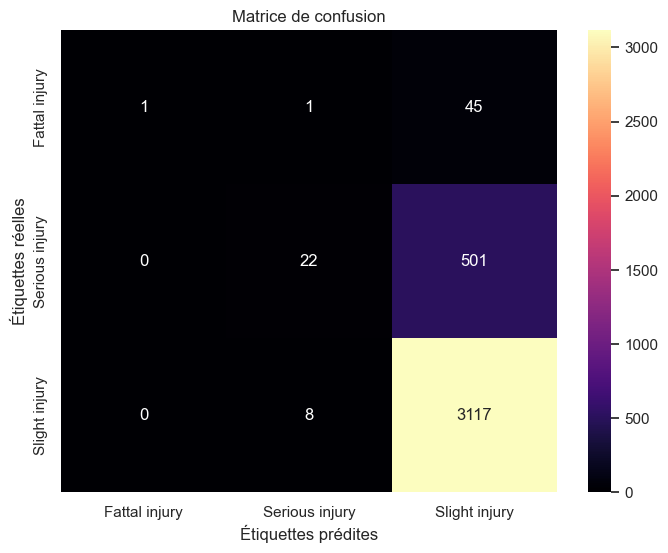

In [ ]:
import mlflow
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred_rf)

# Définir les étiquettes des classes
class_labels = ["Fattal injury", "Serious injury", "Slight injury"]

# Visualisation de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap="magma")
plt.xlabel("Étiquettes prédites")
plt.ylabel("Étiquettes réelles")
plt.title("Matrice de confusion")

# Sauvegarde de la figure
plt.savefig("confusion_matrix.png")

# Enregistrement avec MLflow
with mlflow.start_run():
    mlflow.log_artifact("confusion_matrix.png")


On va enregistrer un modèle de machine learning dans MLflow, en enregistrant le modèle comme artefact, puis en l'ajoutant au registre de modèles sous un nom spécifique pour une gestion centralisée.

In [ ]:
import mlflow
import mlflow.sklearn
if mlflow.active_run():
    mlflow.end_run()

with mlflow.start_run() as run:
    run_id = run.info.run_id
    model_uri = f"runs:/{run_id}/model"

    mlflow.sklearn.log_model(
        sk_model=model_rf,
        artifact_path="model",
        input_example=X_train,
    )

    registered_model = mlflow.register_model(model_uri=model_uri, name="mlflow_accident")


Successfully registered model 'mlflow_accident'.
Created version '1' of model 'mlflow_accident'.


Ce script envoie des données sous forme de requête HTTP POST à un serveur local pour obtenir une prédiction de la sévérité d'un accident. Les données, sous forme de dictionnaire JSON, sont envoyées au modèle de machine learning, et le script récupère et affiche la prédiction (Slight Injury, Serious Injury, Fatal Injury). Dans notre cas le résultat est **slight injury**

In [ ]:
import requests
import json

url = "http://127.0.0.1:1234/invocations"
headers = {"Content-Type": "application/json"}

data = {
    "dataframe_records": [
        {
            'Time': 61320,
            'Day_of_week': 1,
            'Age_band_of_driver': 2,
            'Sex_of_driver': 1,
            'Educational_level': 3,
            'Vehicle_driver_relation': 3,
            'Driving_experience': 1,
            'Type_of_vehicle': 1,
            'Owner_of_vehicle': 1,
            'Service_year_of_vehicle': 3,
            'Defect_of_vehicle': 1,
            'Area_accident_occured': 1,
            'Lanes_or_Medians': 2,
            'Road_allignment': 1,
            'Types_of_Junction': 1,
            'Road_surface_type': 1,
            'Road_surface_conditions': 1,
            'Light_conditions': 2,
            'Weather_conditions': 1,
            'Type_of_collision': 2,
            'Number_of_vehicles_involved': 3,
            'Number_of_casualties': 1,
            'Vehicle_movement': 4,
            'Age_band_of_casualty': 1,
            'Pedestrian_movement': 1,
            'Cause_of_accident': 1,
            'Work_of_casuality': 1,
            'Fitness_of_casuality': 1
        }
    ]
}

# Envoi de la requête POST
response = requests.post(url, headers=headers, data=json.dumps(data))

# Vérification du code de réponse
if response.status_code == 200:
    # Récupération de la prédiction (sévérité)
    result = response.json()
    prediction = result.get('predictions', [None])[0]  # Récupérer la première prédiction

    # Mapping de la prédiction en fonction de la classe
    if prediction == 1:
        print('Slight Injury')
    elif prediction == 2:
        print('Serious Injury')
    elif prediction == 3:
        print('Fatal Injury')
    else:
        print('Unknown Severity')

else:
    print(f"{response.status_code}: {response.text}")


Serious Injury


In [70]:
pip install shap lime

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283840 sha256=5a812db4dbab0b09f9cfec08a5c2f3a21823463706cb3200676ee0b3d0973770
  Stored in directory: c:\users\oumaima\appdata\local\pip\cache\wheels\e7\5d\0e\4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime
Note: you may need to restart the kernel to use updated packages.


## 6. Shap & Lime
### 6.1 SHAP

In [45]:
pip install shap


   ---------------------------------------- 0.0/456.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/456.2 kB ? eta -:--:--
    --------------------------------------- 10.2/456.2 kB ? eta -:--:--
   -- ------------------------------------ 30.7/456.2 kB 435.7 kB/s eta 0:00:01
   --- ----------------------------------- 41.0/456.2 kB 393.8 kB/s eta 0:00:02
   ----- --------------------------------- 61.4/456.2 kB 409.6 kB/s eta 0:00:01
   ------- ------------------------------- 81.9/456.2 kB 416.7 kB/s eta 0:00:01
   ------- ------------------------------- 92.2/456.2 kB 403.5 kB/s eta 0:00:01
   ----------- -------------------------- 143.4/456.2 kB 500.5 kB/s eta 0:00:01
   ---------------- --------------------- 194.6/456.2 kB 588.9 kB/s eta 0:00:01
   ----------------------- -------------- 286.7/456.2 kB 768.0 kB/s eta 0:00:01
   ------------------------------ ------- 368.6/456.2 kB 882.8 kB/s eta 0:00:01
   ---------------------------------------  450.6/456.2 kB 1.0 MB


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [47]:
import shap
# Créer l'explainer avec le meilleur modèle
explainer = shap.TreeExplainer(best_model_lgbm)

In [48]:
# Calcul des valeurs SHAP pour les données de test (X_test) en utilisant l'explainer SHAP.
# Ces valeurs SHAP expliquent l'impact de chaque caractéristique sur les prédictions du modèle.
shap_values = explainer.shap_values(X_test)

In [49]:
shap_values

array([[[ 5.08577694e-01, -1.72341206e-01,  5.37776849e-01],
        [-2.43581913e+00,  1.29628380e-01,  6.58641413e-01],
        [ 9.10229411e-03,  1.60224146e-02, -1.70435030e-02],
        ...,
        [ 7.25047873e-03, -4.64400812e-03,  2.84146054e-04],
        [-4.82176996e-03, -2.78964681e-03,  1.89349324e-02],
        [-2.99506477e-01, -4.78422908e-01,  5.58631397e-01]],

       [[-9.92977656e-01, -4.59228988e-02,  1.97869568e-01],
        [ 8.13665528e-01, -7.00746374e-02, -6.00333978e-03],
        [-1.88701137e-01, -2.13069890e-01,  6.61222443e-02],
        ...,
        [ 8.56501689e-03, -4.50340124e-03,  4.73213695e-04],
        [ 4.67856303e-03, -4.87746497e-02,  1.56066412e-02],
        [-2.73012449e-02, -2.12147927e-01,  3.27499220e-01]],

       [[-2.88497967e+00,  9.88288438e-02,  1.55916604e+00],
        [-1.78165672e+00, -1.24067293e-01,  5.75185852e-01],
        [-1.34600466e-01,  3.34824850e-02,  6.05337145e-02],
        ...,
        [ 7.02201097e-03, -3.16793856e-03,

Number of classes in SHAP values: 3695


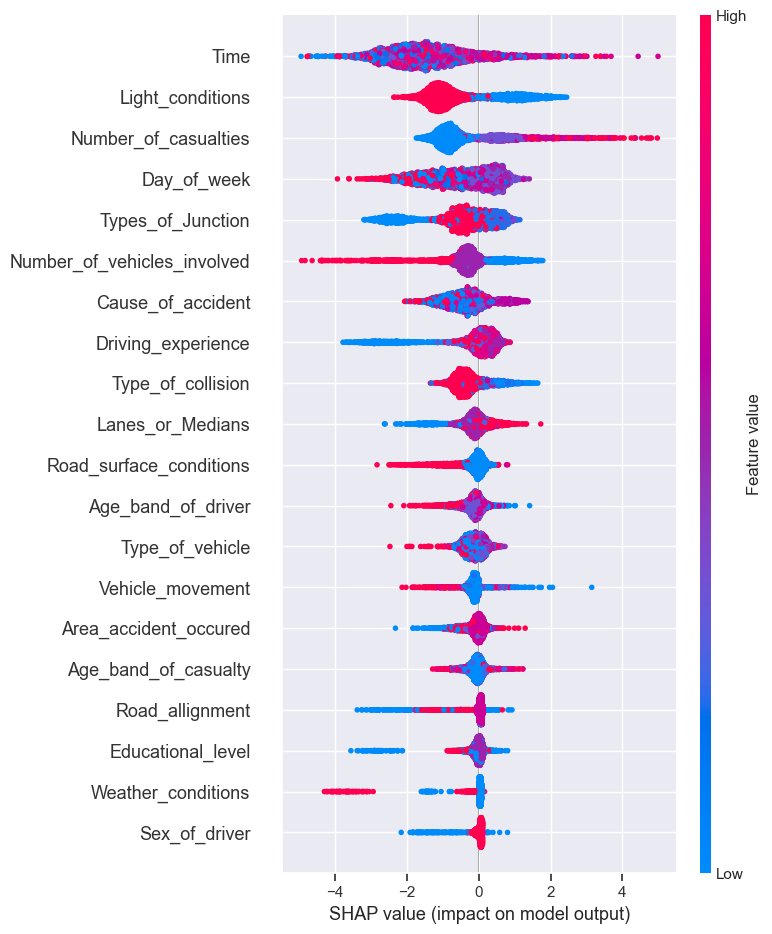

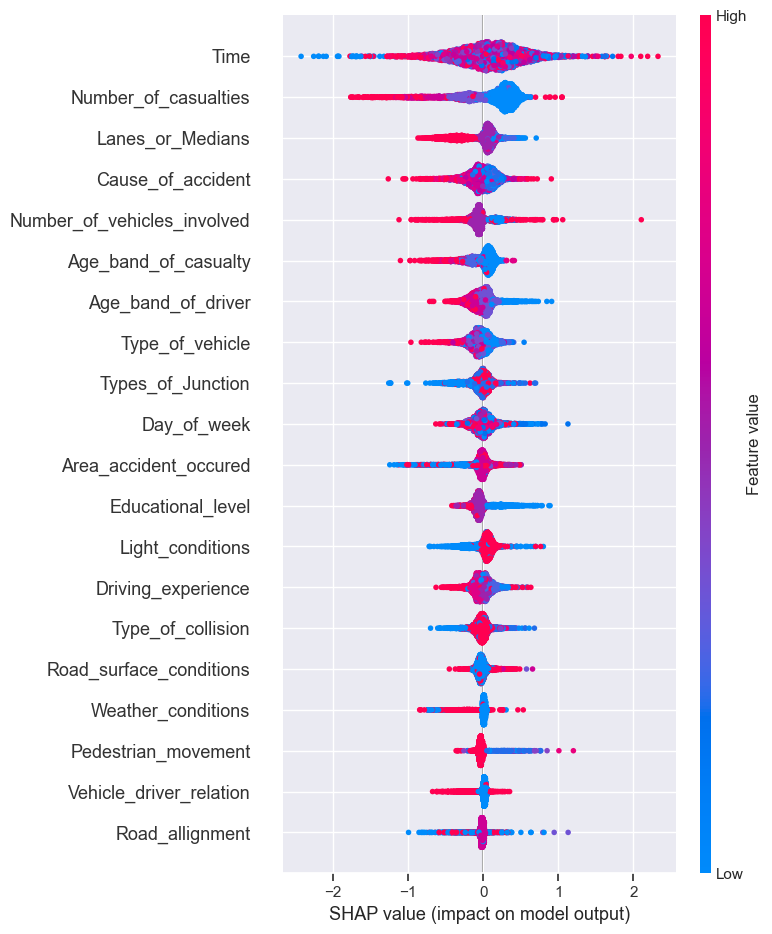

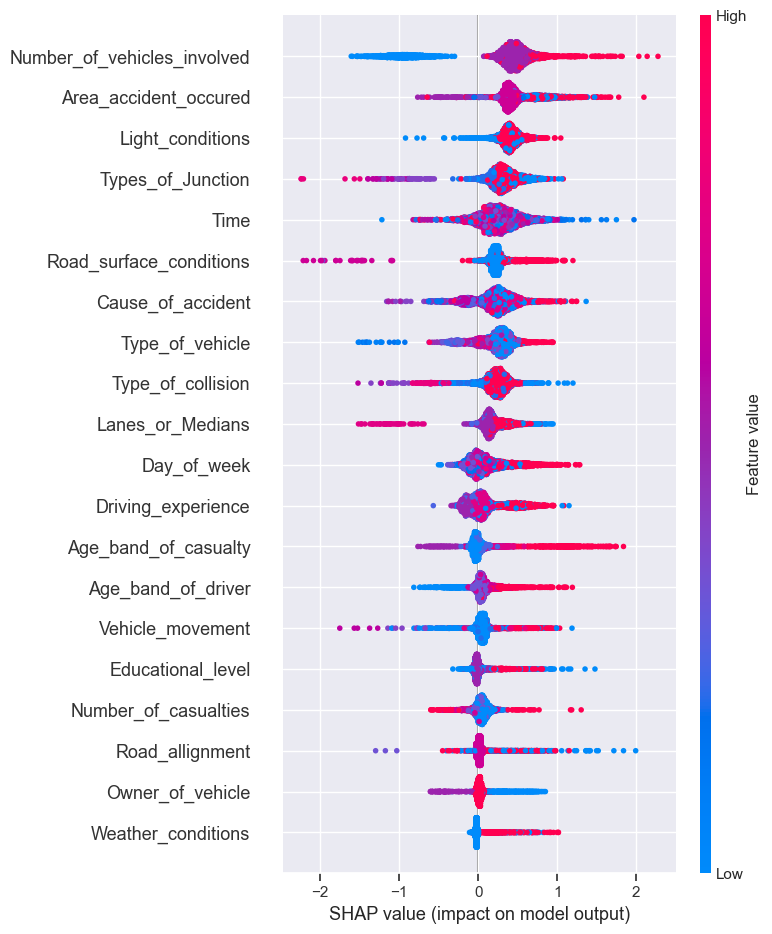

In [50]:
# Afficher le nombre de classes dans les valeurs SHAP
print(f"Number of classes in SHAP values: {len(shap_values)}")

# Pour un modèle multiclasse, créez un graphique de résumé pour chaque classe
# Par exemple, pour la classe 0 (ou une autre classe selon votre besoin):
shap.summary_plot(shap_values[:,:,0], X_test)  # Classe 0
shap.summary_plot(shap_values[:,:,1], X_test)  # Classe 1
shap.summary_plot(shap_values[:,:,2], X_test)  # Classe 2

### Contexte des Graphiques SHAP
- *SHAP (SHapley Additive exPlanations)* est utilisé pour expliquer les prédictions des modèles de machine learning. Dans un contexte de classification multiclasse, chaque classe dispose d'une valeur SHAP qui illustre l'impact de chaque caractéristique sur la probabilité d'appartenance à cette classe.
- Les graphiques *summary_plot* montrent les caractéristiques les plus importantes pour chaque classe.

### Analyse des Résultats
Pour chaque graphique :
1. *Axe Y (Caractéristiques)* : Les caractéristiques (features) du modèle, classées selon leur importance moyenne pour une classe spécifique.
2. *Axe X (Valeurs SHAP)* : L'effet de la caractéristique sur le modèle. Une valeur SHAP positive indique que cette caractéristique augmente la probabilité de prédire la classe concernée, tandis qu'une valeur négative la diminue.
3. *Couleurs* : Représentent les valeurs des caractéristiques (rouge = valeurs élevées, bleu = valeurs faibles).

### Classes et Graphiques
1. *Classe 0 (Fatal Injury)* :
   - Les caractéristiques comme le *nombre de véhicules impliqués* et le *temps de l'accident* ont un impact élevé. Cela signifie que ces caractéristiques influencent fortement la prédiction de blessures mortelles.
   - Exemple : Un *nombre élevé de véhicules impliqués* semble augmenter la probabilité d'un accident fatal (valeurs SHAP positives).

2. *Classe 1 (Serious Injury)* :
   - Des caractéristiques similaires (comme l'âge des conducteurs, le type de croisement) jouent un rôle significatif, mais avec des contributions différentes par rapport à la classe 0.

3. *Classe 2 (Slight Injury)* :
   - Les caractéristiques influençant légèrement les blessures sont différentes. Le modèle se base probablement sur des configurations moins graves des variables (comme moins de véhicules impliqués ou des conditions météorologiques spécifiques).

In [51]:
# Sélection d'une instance spécifique du jeu de données X_test pour l'analyse.
index = 0

# Extraction des valeurs de l'instance sélectionnée.
instance = X_test.iloc[index].values

# Résultat
instance

array([7.122e+04, 0.000e+00, 2.000e+00, 1.000e+00, 4.000e+00, 0.000e+00,
       3.000e+00, 7.000e+00, 0.000e+00, 6.000e+00, 2.000e+00, 5.000e+00,
       5.000e+00, 0.000e+00, 3.000e+00, 2.000e+00, 2.000e+00, 6.000e+00,
       4.000e+00, 4.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 5.000e+00,
       0.000e+00])

In [52]:
# Initialiser les visualisations interactives SHAP dans le navigateur ou l'interface utilisateur.
# Cette fonction charge les scripts nécessaires pour afficher des graphiques interactifs (comme le force plot).
shap.initjs()

# Générer un graphique de type "Force Plot" pour visualiser l'impact des caractéristiques sur la prédiction.
shap.force_plot(explainer.expected_value[1], shap_values[:,:,1][index], instance)

## 6.2 Lime

In [71]:
import lime
from lime import lime_tabular
# Select a single instance
index = 0
instance = X_test.iloc[index].values

In [74]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    class_names=['Fatal injury','Slight Injury','Serious Injury'],
    mode='classification',
    discretize_continuous=True,
)

In [76]:
data.isnull().sum()

Time                           0
Day_of_week                    0
Age_band_of_driver             0
Sex_of_driver                  0
Educational_level              0
Vehicle_driver_relation        0
Driving_experience             0
Type_of_vehicle                0
Owner_of_vehicle               0
Area_accident_occured          0
Lanes_or_Medians               0
Road_allignment                0
Types_of_Junction              0
Road_surface_type              0
Road_surface_conditions        0
Light_conditions               0
Weather_conditions             0
Type_of_collision              0
Number_of_vehicles_involved    0
Number_of_casualties           0
Vehicle_movement               0
Age_band_of_casualty           0
Fitness_of_casuality           0
Pedestrian_movement            0
Cause_of_accident              0
Accident_severity              0
dtype: int64

In [ ]:
# Explain the selected instance
exp = lime_explainer.explain_instance(
    data_row=instance,
    predict_fn=best_model_lgbm.predict_proba,
    num_features=10
)

In [57]:
exp.show_in_notebook(show_table=True)

Ce graphe montre une nouvelle prédiction des probabilités de blessures suite à un accident, ainsi que l'importance et les valeurs des variables utilisées pour cette prédiction.

Le modèle prédit une probabilité élevée de serious injury :
- (Serious Injury) : 100 % (dominant, barre verte).
- (Slight Injury) : 0 % (barre orange).
- (Fatal Injury) : 0 % (faible probabilité).

Les variables les plus significatives pour cette prédiction incluent :
- `Number_of_vehicles_involved`
-  `Age_band_of_driver`
- `Road_allignment`
-  `Type_of_collision	`